In [6]:
import numpy as np
import pandas as pd
import re
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = [10, 5]
import warnings
warnings.simplefilter('ignore')
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

pd.set_option('display.max_columns', 20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Download corpus

In [ ]:
# get the paraphrase corpus in csv format 
# source: http://paraphraser.ru/
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/data.csv

--2022-06-10 05:42:07--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1704539 (1.6M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.62M  --.-KB/s    in 0.05s   

2022-06-10 05:42:07 (30.1 MB/s) - ‘data.csv’ saved [1704539/1704539]



**Annotation**:
 * '1' - strict paraphrases (same meaning)
 * '0' - loose paraphrases (similar meaning)
 * '-1' - non-paraphrases

In [ ]:
df = pd.read_csv('/content/data.csv', index_col= 0)
df.sample(5)

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase
219,225,161,4273,Смольный: Отмена дорожных конкурсов не связана...,Смольный отменил конкурсы на ремонт дорог посл...,-1
3858,4179,3613,7675,"Компания ""Татарстан"" приостановила эксплуатаци...",Компания «Татарстан» приостановила эксплуатаци...,0
2428,2648,2083,6152,В Петербурге задержан генеральный директор ГИПХа.,В Петербурге задержали директора РНЦ «Прикладн...,0
6481,24654,33432,33433,Астрономы нашли гигантское кладбище умерших зв...,"Астрономы нашли ""могилу"" мертвых светил в цент...",0
40,42,20,4127,Взрыв на заправочной станции в Дамаске унес жи...,При взрыве на автозаправке в Дамаске погибли 1...,1


# Preprocessing data

* apply lower register 
* tokenize
* remove unnecessary symbols (except %, currency $, and numbers 123)

In [ ]:
def clean_text(text):
    punctuation = """!"#&\'()*+,-–—./:;<=>?@[\]^_`«»{|}~"""
    text = text.lower()
    tokenized_text = word_tokenize(text)
    cleaned_text = [token for token in tokenized_text if token not in punctuation]
    return cleaned_text

In [ ]:
df["text_1"] = df["text_1"].apply(lambda x:clean_text(x))
df["text_2"] = df["text_2"].apply(lambda x:clean_text(x))

In [ ]:
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0


In [ ]:
# make tuple ('pair_id', 'text_1', 'text_2') to pass each sentence pair to function as an argument

ids = df["pair_id"].tolist()
text_1 = df["text_1"].tolist()
text_2 = df["text_2"].tolist()

pairs_paraphrase = (list(zip(ids, text_1, text_2)))

In [ ]:
pairs_paraphrase[0]

(1,
 ['полицейским',
  'разрешат',
  'стрелять',
  'на',
  'поражение',
  'по',
  'гражданам',
  'с',
  'травматикой'],
 ['полиции',
  'могут',
  'разрешить',
  'стрелять',
  'по',
  'хулиганам',
  'с',
  'травматикой'])

## Lemmatization

apply pymorphy2's class MorphAnalyzer() to morphologically parse each token in a sentence (get lemma and POS-tags)

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 14.5 MB/s 


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

create separate dataset for lemmatized texts

In [ ]:
lemmatized_df = df.copy(deep=True)

In [ ]:
def lemmatize(text):
    parsed_text = [morph.parse(token)[0].normal_form for token in text]
    return parsed_text

In [ ]:
lemmatized_df["text_1"] = lemmatized_df["text_1"].apply(lambda x:lemmatize(x))
lemmatized_df["text_2"] = lemmatized_df["text_2"].apply(lambda x:lemmatize(x))

In [ ]:
lemmatized_df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase
0,1,201,8159,"[полицейский, разрешить, стрелять, на, поражен...","[полиция, мочь, разрешить, стрелять, по, хулиг...",0
1,2,202,8158,"[право, полицейский, на, проникновение, в, жил...","[правило, внесудебный, проникновение, полицейс...",0
2,3,273,8167,"[президент, египет, ввести, чрезвычайный, поло...","[власть, египет, угрожать, ввести, в, страна, ...",0
3,4,220,8160,"[вернуться, из, сирия, россиянин, волновать, в...","[самолёт, мчс, вывезти, россиянин, из, разруши...",-1
4,5,223,8160,"[в, москва, из, сирия, вернуться, 2, самолёт, ...","[самолёт, мчс, вывезти, россиянин, из, разруши...",0


In [ ]:
# make tuples for other functions
text_1_lemm = lemmatized_df["text_1"].tolist()
text_2_lemm = lemmatized_df["text_2"].tolist()

pairs_lemm = list(zip(ids, text_1_lemm, text_2_lemm))

# Feature engineering

## Similarity metrics

compute some common similarity metrics for further comparison with transformations

### Jaccard distance

In [ ]:
def get_jaccard_sim(pairs): 
  jaccard_lst = []
  for pair in pairs:
    tokens1 = set(pair[1]) 
    tokens2 = set(pair[2])
    intersection_ = tokens1.intersection(tokens2)
    jaccard_ = float(len(intersection_)) / (len(tokens1) + len(tokens2) - len(intersection_))
    jaccard_lst.append(jaccard_)
  return jaccard_lst

jaccard_sim_lemm = get_jaccard_sim(pairs_lemm)

In [ ]:
df['jaccard'] = jaccard_sim_lemm
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143


### Levenshtein distance

In [ ]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149875 sha256=a23a618732372eca76c9c88ea4eacd58af450d46a62fb0f7f27b60da246bf9a6
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
def get_lev_dist(pairs): 
    lev_lst = []
    for pair in pairs:
      lev_ = fuzz.token_sort_ratio(pair[1], pair[2])
      lev_lst.append(lev_)
    return lev_lst

lev_dist = get_lev_dist(pairs_paraphrase)

In [ ]:
df['levenshtein'] = lev_dist
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62


## Lexic transformations

### Synonyms

In [ ]:
!pip install wiki-ru-wordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.6 MB 54.9 MB/s 
  Created wheel for wiki-ru-wordnet: filename=wiki_ru_wordnet-1.0.3-py3-none-any.whl size=20890443 sha256=bed68a8567710b341d4eadbdbe5278284f1979df5af781d8b33bcae267cceb2d
  Stored in directory: /root/.cache/pip/wheels/35/43/b7/7dc9d93394ea52e85730fde0ab446267f4855cb6c3a2a137ce
Successfully built wiki-ru-wordnet


In [ ]:
from wiki_ru_wordnet import WikiWordnet
wikiwordnet = WikiWordnet()

We find synonym, hyponym and hypernym transformations with the help of Wikiwordnet module ((https://wiki-ru-wordnet.readthedocs.io/en/latest/)

Wikiwordnet uses Wiktionary as a dictionary

We look only for **content words: nouns, verbs, adjectives, adverbs**.
Function words (prepositions, pronouns, conjuctions, particles) have very little substantive meaning and primarily denote grammatical relationships between content words (some prepositions are highly polysemantic also).

Pymorphy2 tags: http://opencorpora.org/dict.php?act=gram

In [ ]:
def find_synonyms(pairs): 
    label_lst = []
    synonym_pairs = []
    pair_ids = []
    function_tags = ['NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ']

    for pair in pairs:
      found = [] # put all synonyms found in 1 pair here
      label = 0

      for token in pair[1]:
        p = morph.parse(token)[0]
        if p.tag.POS not in function_tags:
          # synset includes the token and group(s) of its synonyms 
          # if the token is polysemantic, there are groups of its synonyms for each meaning of the token
          synsets = wikiwordnet.get_synsets(token)
          if len(synsets) != 0:
            synonym_group = []
            for synset in synsets:
              synonyms = [w.lemma() for w in synset.get_words() if w.lemma() != token]
              if len(synonyms) != 0:
                synonym_group.extend(synonyms)
            for item in synonym_group:
              if item in pair[2]:
                label += 1
                found.append(str(label) + ') ' + token + ', ' + item)
                
      synonym_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    # returns list of (synonyms, label) tuples
    return list(zip(pair_ids, synonym_pairs, label_lst))

Example:

In [ ]:
%%time
synonyms = find_synonyms(pairs_lemm)

positives = []
for item in synonyms:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
synonym_found = [' '.join(result[1]) for result in positives]
syn_counter = [result[2] for result in positives]

syn_df = pd.DataFrame({'pair_id': pair_ids, 'synonyms': synonym_found, 'syn_counter': syn_counter})

CPU times: user 18.2 s, sys: 72.9 ms, total: 18.3 s
Wall time: 18.4 s


In [ ]:
syn_df.sample(10)

,pair_id,synonyms,syn_counter
200,25289,"1) исполнение, выполнение",1
159,6488,"1) коалиция, альянс",1
82,2895,"1) зал, зала",1
5,228,"1) начальник, глава",1
155,6339,"1) возрасти, увеличиться",1
109,3873,"1) корабль, судно",1
81,2847,"1) избрать, выбрать",1
57,1799,"1) снизиться, уменьшиться",1
10,317,"1) метрополитен, метро",1
134,4483,"1) петербургский, питерский",1


In [ ]:
syn_df.shape

(203, 3)

Add labels to data

In [ ]:
syn_labels = [pair[2] for pair in synonyms]
df['synonyms'] = syn_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0


### Hyponyms

In [ ]:
def find_hyponyms(pairs): 
    label_lst = []
    hyponym_pairs = []
    pair_ids = []
    function_tags = ['NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ']

    for pair in pairs:
      found = [] # put all hyponyms found in 1 pair here
      label = 0

      for token in pair[1]:
        p = morph.parse(token)[0]
        if p.tag.POS not in function_tags:
          synsets = wikiwordnet.get_synsets(token)
          if len(synsets) != 0:
            hyponym_group = []
            for synset in synsets:
              # get hyponyms from each synset
              for hyponym in wikiwordnet.get_hyponyms(synset):
                hyponyms = [w.lemma() for w in hyponym.get_words() if w.lemma() != token]
                if len(hyponyms) != 0:
                  hyponym_group.extend(hyponyms)
            for item in hyponym_group:
              if item in pair[2]:
                label += 1
                found.append(str(label) + ') ' + token + ', ' + item)
                
      hyponym_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    # returns list of (hyponyms, label) tuples
    return list(zip(pair_ids, hyponym_pairs, label_lst))

Example:

In [ ]:
%%time
hyponyms = find_hyponyms(pairs_lemm)

positives = []
for item in hyponyms:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
hyponym_found = [' '.join(result[1]) for result in positives]
hyp_counter = [result[2] for result in positives]

hyp_df = pd.DataFrame({'pair_id': pair_ids, 'hyponyms': hyponym_found, 'hyp_counter': hyp_counter})

CPU times: user 18.4 s, sys: 42 ms, total: 18.4 s
Wall time: 18.5 s


In [ ]:
hyp_df.sample(10)

,pair_id,hyponyms,hyp_counter
0,14,"1) гражданин, согражданин",1
2,77,"1) прибыть, прилететь",1
61,2140,"1) автор, писатель 2) автор, писатель",2
64,2232,"1) исполнить, спеть",1
15,529,"1) преступник, убийца",1
95,3577,"1) соперник, конкурент",1
86,3289,"1) российский, петербургский",1
94,3568,"1) лидер, президент",1
98,3727,"1) награда, премия",1
17,562,"1) моряк, пират",1


In [ ]:
hyp_df.shape

(205, 3)

Add labels to data

In [ ]:
hyp_labels = [pair[2] for pair in hyponyms]
df['hyponyms'] = hyp_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0


### Hypernyms

In [ ]:
def find_hypernyms(pairs): 
    label_lst = []
    hypernym_pairs = []
    pair_ids = []
    function_tags = ['NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ']

    for pair in pairs:
      found = [] # put all hyponyms found in 1 pair here
      label = 0

      for token in pair[1]:
        p = morph.parse(token)[0]
        if p.tag.POS not in function_tags:
          synsets = wikiwordnet.get_synsets(token)
          if len(synsets) != 0:
            hypernym_group = []
            for synset in synsets:
              # get hypernyms from each synset
              for hypernym in wikiwordnet.get_hypernyms(synset):
                hypernyms = [w.lemma() for w in hypernym.get_words() if w.lemma() != token]
                if len(hypernyms) != 0:
                  hypernym_group.extend(hypernyms)
            for item in hypernym_group:
              if item in pair[2]:
                label += 1
                found.append(str(label) + ') ' + token + ', ' + item)
                
      hypernym_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    # returns list of (hypernyms, label) tuples
    return list(zip(pair_ids, hypernym_pairs, label_lst))

Example:

In [ ]:
%%time
hypernyms = find_hypernyms(pairs_lemm)

positives = []
for item in hypernyms:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
hypernym_found = [' '.join(result[1]) for result in positives]
hyper_counter = [result[2] for result in positives]

hyper_df = pd.DataFrame({'pair_id': pair_ids, 'hypernyms': hypernym_found, 'hyper_counter': hyper_counter})

CPU times: user 17.1 s, sys: 34.1 ms, total: 17.1 s
Wall time: 17.1 s


In [ ]:
hyper_df.sample(10)

,pair_id,hypernyms,hyper_counter
105,6459,"1) взрыв, теракт",1
82,3739,"1) кампус, территория",1
22,810,"1) банк, организация",1
132,24471,"1) вспыхнуть, загореться",1
62,2961,"1) берег, область",1
53,2543,"1) сын, новорождённый",1
91,4286,"1) наклеивать, клеить",1
55,2732,"1) главарь, лидер",1
95,4843,"1) театр, здание",1
23,965,"1) главврач, врач",1


In [ ]:
hyper_df.shape

(154, 3)

Add labels to data

In [ ]:
hyper_labels = [pair[2] for pair in hypernyms]
df['hypernyms'] = hyper_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0


### Symbols (semiotic system transformation)

get file with typographical symbols and their lexeme equivalent

In [ ]:
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/symbols.txt

--2022-06-10 05:44:52--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/symbols.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80 [text/plain]
Saving to: ‘symbols.txt’

symbols.txt         100%[===================>]      80  --.-KB/s    in 0s      

2022-06-10 05:44:52 (3.74 MB/s) - ‘symbols.txt’ saved [80/80]



The file contains **symbol** and **regular expression** with its word equivalent. We chose regular expression to find not only nouns, but also adjectives with the same stem (e.g. *3% - трехпроцентный*) 

Find **currency ($, €, ₽)** and **percentage (%)** symbols transformations (symbols were chosen due to the discourse of the material - news headlines)

In [ ]:
def find_symbols(pairs, file): 
    label_lst = []
    symbol_pairs = []
    pair_ids = []

    # make dictionary from input file where symbol is KEY and regex is VALUE
    d = {}
    with open(file, encoding='utf-8') as file:
      for line in file:
        key, value = line.split()
        d[key] = value
    print(f'View the dictionary: {d}')

    for pair in pairs:
      found = []
      label = 0

      for key in d.keys():
        # text_1 contains symbol, text_2 contains word
        if key in pair[1]:
          regex_1 = re.compile(d[key])
          word_1 = re.findall(regex_1, ' '.join(pair[2]))
          if len(word_1) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_1))

        # text_2 contains symbol, text_1 contains word
        if key in pair[2]:
          regex_2 = re.compile(d[key])
          word_2 = re.findall(regex_2, ' '.join(pair[1]))
          if len(word_2) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_2))

      symbol_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])

    return list(zip(pair_ids, symbol_pairs, label_lst))

Example:

In [ ]:
symbols = find_symbols(pairs_lemm, '/content/symbols.txt')

positives = []
for item in symbols:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
symbol_found = [' '.join(result[1]) for result in positives]
symb_counter = [result[2] for result in positives]

symb_df = pd.DataFrame({'pair_id': pair_ids, 'symbols': symbol_found, 'symb_counter': symb_counter})

View the dictionary: {'%': 'процент\\w*', '€': 'евро(?!\\w)', '₽': 'рубл\\w+', '$': 'дол?лар\\w*'}


In [ ]:
symb_df.sample(5)

,pair_id,symbols,symb_counter
8,707,"1) $, доллар",1
25,7276,"1) $, доллар",1
18,3826,"1) $, доллар",1
13,1873,"1) $, доллар",1
7,630,"1) %, процент",1


In [ ]:
symb_df.shape

(36, 3)

Add labels to data

In [ ]:
symbol_labels = [pair[2] for pair in symbols]
df['symbols'] = symbol_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0


### Numbers

to convert numbers into strings we're using **ru_number_to_text** module (source: https://github.com/seriyps/ru_number_to_text)

In [ ]:
!pip install git+https://github.com/seriyps/ru_number_to_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/seriyps/ru_number_to_text to /tmp/pip-req-build-cv4dqu27
  Running command git clone -q https://github.com/seriyps/ru_number_to_text /tmp/pip-req-build-cv4dqu27
  Created wheel for num2t4ru: filename=num2t4ru-2.0.0-py3-none-any.whl size=7431 sha256=2bc538dff916b15dbc16c6c241e34ceb039259d672ea4fc9936a0fadb1c3cbb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-t16wujkg/wheels/d7/d4/13/a078e7ab4af12e6e39bd2e316f5c17fef4d6052479aa5955e4
Successfully built num2t4ru


In [ ]:
from num2t4ru import num2text

We will work only with integers (fractions like 1,8 and 1.347 are not currently supported)

In [ ]:
def find_numbers(pairs): 
    label_lst = []
    number_pairs = []
    pair_ids = []
    
    fraction = re.compile('\d+\,|\.\d+')

    for pair in pairs:
      found = []
      label = 0
      
      # text_1 contains symbol, text_2 contains word
      for token in pair[1]:
        p = morph.parse(token)[0]
        if 'NUMB' in p.tag:
          # the number must not be a fraction or decimal
          if len(fraction.findall(token)) == 0:
            if num2text(int(token)) in pair[2]:
              label += 1
              found.append(str(label) + ') ' + token + ', ' + num2text(int(token)))
      
      # text_2 contains symbol, text_1 contains word
      for token in pair[2]:
        p = morph.parse(token)[0]
        if 'NUMB' in p.tag:
          if len(fraction.findall(token)) == 0:
            if num2text(int(token)) in pair[1]:
              label += 1
              found.append(str(label) + ') ' + token + ', ' + num2text(int(token)))


      number_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])

    return list(zip(pair_ids, number_pairs, label_lst))

Example:

In [ ]:
numbers = find_numbers(pairs_lemm)

positives = []
for item in numbers:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
number_found = [' '.join(result[1]) for result in positives]
num_counter = [result[2] for result in positives]

num_df = pd.DataFrame({'pair_id': pair_ids, 'numbers': number_found, 'num_counter': num_counter})

In [ ]:
num_df.sample(10)

,pair_id,numbers,num_counter
15,1873,"1) 5, пять",1
38,3446,"1) 2, два",1
1,184,"1) 2, два",1
32,3001,"1) 3, три",1
34,3146,"1) 2, два",1
4,1004,"1) 100, сто",1
59,24252,"1) 9, девять",1
43,4289,"1) 10, десять",1
2,554,"1) 7, семь",1
11,1811,"1) 2, два",1


In [ ]:
num_df.shape

(71, 3)

Add labels to data

In [ ]:
number_labels = [pair[2] for pair in numbers]
df['numbers'] = number_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0


### Contractions (shortened forms)

By contractions (shortened forms) here we mean:
* **graphic contractions** where syllables or letters in the middle of the words are omitted (*кг - килограмм*)
* **apocope** where the final letters or syllables of the word are omitted (*руб - рубль*)

Contractions standard is 'ГОСТ 7.0.12-2011' 

We chose most common shortened forms:
* units of measurement in SI system (length, mass, volume, area, and time)
* currency (*руб, р, долл*)
* numbers (тыс, млн, млрд, трлн)

This transformation is hard to detect properly due to the fact that some contractions are actually **ambiguous**:
* в (shortened form for unit of time 'век' and a preposition)
* м/мин (two common forms for the word 'минута')
* г (either 'грамм' or 'год')
* а (either unit of area 'ар' or a conjunction)

In [ ]:
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/short_forms.txt

--2022-06-10 05:45:28--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/short_forms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586 [text/plain]
Saving to: ‘short_forms.txt’

short_forms.txt     100%[===================>]     586  --.-KB/s    in 0s      

2022-06-10 05:45:29 (24.8 MB/s) - ‘short_forms.txt’ saved [586/586]



In [ ]:
def find_short_forms(pairs, file): 
    label_lst = []
    short_form_pairs = []
    pair_ids = []

    # make dictionary from input file where short form is KEY and regex is VALUE
    d = {}
    with open(file, encoding='utf-8') as file:
      for line in file:
        key, value = line.split()
        d[key] = value
    print(f'View the dictionary: {d}')

    for pair in pairs:
      found = []
      label = 0

      for key in d.keys():
        # text_1 contains short form, text_2 contains word
        if key in pair[1]:
          regex_1 = re.compile(d[key])
          word_1 = re.findall(regex_1, ' '.join(pair[2]))
          if len(word_1) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_1))

        # text_2 contains short form, text_1 contains word
        if key in pair[2]:
          regex_2 = re.compile(d[key])
          word_2 = re.findall(regex_2, ' '.join(pair[1]))
          if len(word_2) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_2))

      short_form_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    
    return list(zip(pair_ids, short_form_pairs, label_lst))

Example:

In [ ]:
short_forms = find_short_forms(pairs_lemm, '/content/short_forms.txt')

positives = []
for item in short_forms:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
short_form_found = [' '.join(result[1]) for result in positives]
short_form_counter = [result[2] for result in positives]

short_forms_df = pd.DataFrame({'pair_id': pair_ids, 'short_forms': short_form_found, 'short_form_counter': short_form_counter})

View the dictionary: {'мм': 'милиметр\\w*', 'см': 'сантиметр\\w*', 'дм': 'дециметр\\w*', 'м': 'метр(?!\\w)|метров|метром|метр(?!о)\\w+', 'км': 'километр\\w*', 'мг': 'милиграмм\\w*', 'кг': 'килограмм\\w*', 'ц': 'центнер\\w*', 'т': 'тонн\\w*', 'мл': 'миллилитр\\w*', 'л': 'литр\\w*', 'га': 'гектар\\w*', 'мин': 'минут\\w*', 'сек': 'секунд\\w*', 'ч': 'час\\w*', 'сут': 'суто?\\w*', 'г': 'год\\w*', 'вв': 'век\\w*', 'руб': 'рубл\\w+', 'р': 'рубл\\w+', 'долл': 'дол?лар\\w*', 'тыс': 'тысяч\\w*', 'млн': 'миллион\\w*', 'млрд': 'миллиард\\w*', 'трлн': 'триллион\\w*'}


In [ ]:
short_forms_df.sample(10)

,pair_id,short_forms,short_form_counter
206,24660,"1) тыс, тысяча",1
148,4858,"1) руб, рубль 2) трлн, триллион",2
66,2189,"1) тыс, тысяча",1
96,3143,"1) кг, килограмм",1
21,422,"1) млрд, миллиард",1
12,208,"1) долл, доллар 2) млрд, миллиард",2
113,3572,"1) руб, рубль 2) млн, миллион",2
121,3893,"1) млн, миллион",1
47,1272,"1) долл, доллар",1
149,4860,"1) долл, доллар 2) млрд, миллиард",2


In [ ]:
short_forms_df.shape

(223, 3)

Add labels to data

In [ ]:
short_form_labels = [pair[2] for pair in short_forms]
df['short_forms'] = short_form_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0


### Abbreviations

In this section, we look for common abbreviations which can be substituted for full form of the word/phrase and vice versa

The abbreviations were chosen is accordance with corpus discourse - politics, news (e.g. *США - Америка, ВМФ - флот*)

In [ ]:
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/abbreviations.txt

--2022-06-10 09:21:13--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/abbreviations.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1295 (1.3K) [text/plain]
Saving to: ‘abbreviations.txt’

abbreviations.txt   100%[===================>]   1.26K  --.-KB/s    in 0s      

2022-06-10 09:21:13 (63.1 MB/s) - ‘abbreviations.txt’ saved [1295/1295]



In [ ]:
def find_abbr(pairs, file): 
    label_lst = []
    abbr_pairs = []
    pair_ids = []

    # make dictionary from input file where abbreviation is KEY and regex is VALUE
    d = {}
    with open(file, encoding='utf-8') as file:
      for line in file:
        key, value = line.split()
        d[key] = value
    print(f'View the dictionary: {d}')

    for pair in pairs:
      found = []
      label = 0

      for key in d.keys():
        # text_1 contains abbr, text_2 contains full form
        if key in pair[1]:
          regex_1 = re.compile(d[key])
          word_1 = re.findall(regex_1, ' '.join(pair[2]))
          if len(word_1) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_1))

        # text_2 contains abbr, text_1 contains full form
        if key in pair[2]:
          regex_2 = re.compile(d[key])
          word_2 = re.findall(regex_2, ' '.join(pair[1]))
          if len(word_2) != 0:
            label += 1
            found.append(str(label) + ') ' + key + ', ' + ''.join(word_2))

      abbr_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    
    return list(zip(pair_ids, abbr_pairs, label_lst))

Example:

In [ ]:
abbr = find_abbr(pairs_lemm, '/content/abbreviations.txt')

positives = []
for item in abbr:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
abbr_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

abbr_df = pd.DataFrame({'pair_id': pair_ids, 'abbr_word': abbr_found, 'counter': counter})

View the dictionary: {'rub': 'рубл\\w+', 'eur': 'евро(?!\\w)', 'usd': 'дол?лар\\w*', 'рф': 'российск\\w+\\sфедераци\\w+|росси\\w{1,3}', 'сша': 'соедин[е|ё]нны\\w+\\sштат\\w+\\sамерик\\w+|соедин[е|ё]нны\\w+\\sштат\\w+|америк\\w+', 'вуз': 'высш\\w+\\sучебн\\w+\\sзаведени\\w+|университет\\w*', 'спб': 'питер\\w+|санкт-?петербур[г|ж]\\w*|петербург\\w*', 'мск': 'моско?в\\w+', 'ес': 'европейск\\w+\\sсоюз\\w*|европ\\w+', 'вс': 'вооруженны\\w+\\sсил\\w*', 'ввп': 'внутренн\\w+\\sвалов\\w+\\sпродукт\\w*', 'ввс': 'военно-?воздушны\\w+\\sсил\\w*', 'вмф': 'военно-?морско\\w+\\sфлот\\w*|флот\\w*', 'чп': 'происшестви\\w+|авари\\w+', 'зампред': 'заместител\\w+\\sпредседателя', 'замминстр': 'заместител\\w+\\sминистра', 'цб': 'центральн\\w+\\sбанк\\w*|банк\\w*', 'дтп': 'дорожно-?транспортн\\w+\\sпроисшеств\\w+|происшестви\\w+', 'фмс': 'федеральн\\w+\\sмиграционн\\w+\\sслужб\\w+', 'цру': 'разведк\\w+', 'фсб': 'федеральн\\w+\\sслужб\\w+\\sбезопасности', 'мвд': 'милиц\\w+|полиц\\w+|правоохранительны\\w+\\sо

In [ ]:
abbr_df.sample(10)

,pair_id,abbr_word,counter
45,3121,"1) мвд, полиция",1
116,24098,"1) сша, американский",1
86,5336,"1) цб, банк 2) цб, банк",2
122,24463,"1) сша, американский",1
57,3895,"1) цб, банкбанк",1
1,35,"1) рф, россия",1
109,7262,"1) цб, банкбанк",1
18,1406,"1) сша, американский",1
113,23797,"1) сша, американский",1
3,44,"1) сша, американский",1


In [ ]:
abbr_df.shape

(154, 3)

Add labels to data

In [ ]:
abbr_labels = [pair[2] for pair in abbr]
df['abbreviations'] = abbr_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,...,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,...,0,0,0,0,0,0,0,0,0,0


### Verb derivation

Texts often have synonymous words with the same stem (e.g. *явиться - появиться*)

In this section, we will look for such transformations where a prefix added to a verb with the same stem

In [ ]:
def find_derv(pairs):
    label_lst = []
    derv_pairs = []
    pair_ids = []
    prefixes = ['в', 'во', 'вз', 'взо', 'воз', 'возо', 'вы', 'до', 'за', 'из', 'изо', 'на', 'о', 'об', 
                'обо', 'от', 'ото', 'по', 'под', 'подо', 'пре', 'пред', 'предо', 'при', 'про', 'раз', 'разо', 
                'y', 'с', 'со']
    
    for pair in pairs:
      found = []
      label = 0
      
      # {verb:tag}
      verbs1 = {}
      for token in pair[1]:
        p = morph.parse(token)[0]
        if p.tag.POS == 'INFN':
          verbs1[token] = p.tag.POS
      
      verbs2 = {}
      for token in pair[1]:
        p = morph.parse(token)[0]
        if p.tag.POS == 'INFN':
          verbs2[token] = p.tag.POS
  
      for key in verbs1.keys():
        for prefix in prefixes:
          prefix = '^' + prefix
          regex = re.compile(prefix)
          result = re.sub(regex, '', key)
          if len(result) < len(key): # if len(word with prefix) < len(word)
            if result in verbs2.keys():
              label += 1
              found.append(f'{str(label)}) {key} - {result}')
      
      for key in verbs2.keys():
        for prefix in prefixes:
          prefix = '^' + prefix
          regex = re.compile(prefix)
          result = re.sub(regex, '', key)
          if len(result) < len(key):
            if result in verbs1.keys():
              label += 1
              found.append(f'{str(label)}) {key} - {result}')
     
      derv_pairs.append(found)
      label_lst.append(label)
      pair_ids.append(pair[0])
    
    return list(zip(pair_ids, derv_pairs, label_lst))

In [ ]:
derv = find_derv(pairs_lemm)

positives = []
for item in derv:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
derv_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

derv_df = pd.DataFrame({'pair_id': pair_ids, 'derv_verb': derv_found, 'counter': counter})

In [ ]:
derv_df.head()

,pair_id,derv_verb,counter


As we haven't found any derivative verb transformation, we won't include this as feature in data

## Syntactic transformations

### Voice change

For finding voice change transformation, we will use Natasha python library instead or pymorphy2, because pymorphy often fails to detect verb or participle voice

In [ ]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 136 kB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=e795ae552183f3210082f0279931030f2959bbbef00075d044913d051c8c78d6
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [ ]:
word1 = 'построен'
p1 = morph.parse(word1)[0]
print(word1, 'voice:', p1.tag.voice)

word2 = 'строят'
p2 = morph.parse(word2)[0]
print(word2, 'voice', p2.tag.voice)

word3 = 'строился'
p3 = morph.parse(word3)[0]
print(word3, 'voice', p3.tag.voice)

word4 = 'оделась'
p4 = morph.parse(word4)[0]
print(word4, 'voice', p4.tag.voice)

построен voice: pssv
строят voice None
строился voice None
оделась voice None


In [ ]:
text = 'Построен дом. Строят дом. Строился дом. Построенный дом. Делающий задание. Она оделась.'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
for item in doc.tokens:
  if item.pos == 'VERB':
    print(item.text, item.pos, item.feats['Voice'])

Построен VERB Pass
Строят VERB Act
Строился VERB Pass
Построенный VERB Pass
Делающий VERB Act
оделась VERB Mid


Natasha, as compared to pymorphy2, is able to classify form 'строился' as passive voice and 'оделась' as middle (reflexive) voice

In this section, we will look for:
* active -> passive voice transformation (and vice versa)
* active -> middle voice transformation (and vice versa)

**Middle voice**:
* VERB (Mid)

**Active voice**:
* VERB (Act)
* PARTICIPLE (Act)

**Passive voice**:
* VERB (Pass)
* PARTICIPLE (Pass)

Since Natasha classifies all verb forms (participle, infinitive, finite verbs) as VERB, voice transformations are easier to find

In [ ]:
lemmatized = {token.lemma: [token.text, token.feats['Voice']] for token in doc.tokens if token.pos == 'VERB' and 'Voice' in token.feats.keys()}
lemmatized

{None: ['оделась', 'Mid']}

In [ ]:
def find_voice_change(pairs):
  label_lst = []
  voice_pairs = []
  pair_ids = []
  tags_lst = []
  
  for pair in pairs:
    found = []
    label = 0
    tags = []
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    # lemmatize sents and create a dictionary {'verb lemma': [='word form', 'voice']}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    lemmatized1 = {token.lemma: [token.text, token.feats['Voice']] for token in doc1.tokens if token.pos == 'VERB' and
                   'Voice' in token.feats.keys()}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    lemmatized2 = {token.lemma: [token.text, token.feats['Voice']] for token in doc2.tokens if token.pos == 'VERB' and
                   'Voice' in token.feats.keys()}
    """
    algorithm:
    1) look for similar VERB LEMMAS in dictionaries keys
    2) check if they have different voice tags in values
    """
    for key in lemmatized1.keys():
      if key in lemmatized2.keys() and lemmatized1[key][1] != lemmatized2[key][1]:
        label += 1
        found.append(str(label) + ') ' + lemmatized1[key][0] + ', ' + lemmatized2[key][0])
        tags.append(lemmatized1[key][1] + '->' + lemmatized2[key][1])

    voice_pairs.append(found)
    tags_lst.append(tags)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, tags_lst, voice_pairs, label_lst))

Example:

In [ ]:
%%time
voice_change = find_voice_change(pairs_paraphrase)

positives = []
for item in voice_change:
  if item[3] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
verbs_found = [' '.join(result[2]) for result in positives]
tags_found = [' '.join(result[1]) for result in positives]
voice_counter = [result[3] for result in positives]

voice_df = pd.DataFrame({'pair_id': pair_ids, 'verbs': verbs_found, 'tags': tags_found, 'counter': voice_counter})

CPU times: user 1min 5s, sys: 40.9 s, total: 1min 46s
Wall time: 56.3 s


In [ ]:
voice_df.sample(10)

,pair_id,verbs,tags,counter
368,25136,"1) восстановлено, восстановили",Pass->Act,1
140,2404,"1) задержаны, задержали",Pass->Act,1
322,24269,"1) эвакуированы, эвакуировали",Pass->Act,1
136,2332,"1) захвачен, захватили",Pass->Act,1
56,974,"1) обвинен, обвинили",Pass->Act,1
240,4234,"1) вызван, вызвали",Pass->Act,1
85,1395,"1) выдвинут, выдвинули",Pass->Act,1
308,7260,"1) перенесен, перенесли",Pass->Act,1
232,4030,"1) задержали, задержан",Act->Pass,1
265,4508,"1) задержали, задержан",Act->Pass,1


In [ ]:
voice_df.shape

(377, 4)

Add labels to data

In [ ]:
voice_labels = [pair[3] for pair in voice_change]
df['voice_change'] = voice_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0


### Adjectivization

In this section, we find sentences where finite verb or infinitive was substituted by its participle form

In [ ]:
text = 'Построить дом. Построенный дом. Построят дом.'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
for item in doc.tokens:
  if item.pos == 'VERB':
    print(item.text, item.pos, item.feats['VerbForm'])

Построить VERB Inf
Построенный VERB Part
Построят VERB Fin


In [ ]:
for token in doc.tokens:
      token.lemmatize(morph_vocab)

for token in doc.tokens:
  if token.pos == 'VERB':
    print(token.text, '-', token.lemma)

Построить - построить
Построенный - построить
Построят - построить


* Inf - infinitive
* Part - Participle
* Fin - finite form

In [ ]:
def find_adj_verb(pairs):
  label_lst = []
  adj_pairs = []
  pair_ids = []
  verbs = ['Inf', 'Fin']
  
  for pair in pairs:
    found = []
    label = 0
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)
    # lemmatize sents and create a dictionary {'verb lemma': ['word form', 'verb form']}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    lemmatized1 = {token.lemma: [token.text, token.feats['VerbForm']] for token in doc1.tokens if token.pos == 'VERB' 
                   and 'VerbForm' in token.feats}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    lemmatized2 = {token.lemma: [token.text, token.feats['VerbForm']] for token in doc2.tokens if token.pos == 'VERB' 
                   and 'VerbForm' in token.feats}
    """
    algorithm:
    1) look for similar VERB LEMMAS in dictionaries keys
    2) check if one sentence has VERB and another one has PART
    """
    for key in lemmatized1.keys():
      if key in lemmatized2.keys():
        if lemmatized1[key][1] in verbs and lemmatized2[key][1] == 'Part':
          label += 1
          found.append(str(label) + ') ' + lemmatized1[key][0] + ', ' + lemmatized2[key][0])
        elif lemmatized2[key][1] in verbs and lemmatized1[key][1] == 'Part':
          label += 1
          found.append(str(label) + ') ' + lemmatized2[key][0] + ', ' + lemmatized1[key][0])

    adj_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, adj_pairs, label_lst))

Example:

In [ ]:
%%time
adj_change = find_adj_verb(pairs_paraphrase)

positives = []
for item in adj_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
adj_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

adj_verb_df = pd.DataFrame({'pair_id': pair_ids, 'adj_verb': adj_found, 'counter': counter})

CPU times: user 2min 5s, sys: 1min 15s, total: 3min 20s
Wall time: 1min 42s


In [ ]:
adj_verb_df.head()

,pair_id,adj_verb,counter
0,48,"1) ввели, введены",1
1,54,"1) погибли, погибших",1
2,56,"1) приостановила, приостановлена",1
3,59,"1) нашли, найден",1
4,80,"1) ввели, введен",1


In [ ]:
adj_verb_df.shape

(465, 3)

Add labels to data

In [ ]:
adj_labels = [pair[2] for pair in adj_change]
df['adjectivization'] = adj_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0,0


### Adverbialization

In this section, we look for transformations when a finite verb takes an adverbial form (*трансформация в деепричастный оборот или придаточное с обстоятельственным значением*)

In [ ]:
text = 'Он побежал, уронил телефон'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.rel)

Он nsubj
побежал root
, punct
уронил conj
телефон obj


A **conjunct (сonj)** is the relation between two elements connected by a coordinating conjunction, such as and, or, etc.

In [ ]:
text = 'Он побежал, уронив телефон'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for token in doc.tokens:
      token.lemmatize(morph_vocab)
for item in doc.tokens:
  if item.pos == 'VERB':
    print(item.text, item.lemma, item.rel)

побежал побежать root
уронив уронить advcl


An **adverbial clause modifier (advcl)** is a clause which modifies a verb or other predicate (adjective, etc.), as a modifier not as a core complement. 

In [ ]:
def find_adv_verb(pairs):
  label_lst = []
  adv_pairs = []
  pair_ids = []
  
  for pair in pairs:
    found = []
    label = 0
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)
    # lemmatize sents and create a dictionary {'lemma': ['word form', 'rel']}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    lemmatized1 = {token.lemma: [token.text, token.rel] for token in doc1.tokens if token.pos == 'VERB'}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    lemmatized2 = {token.lemma: [token.text, token.rel] for token in doc2.tokens if token.pos == 'VERB'}
    """
    algorithm:
    1) look for similar VERB LEMMAS in dictionaries keys
    2) check if one sentence has VERB advcl and another sent has non-advcl VERB (root, conj)
    """
    for key in lemmatized1.keys():
      if key in lemmatized2.keys():
        if lemmatized1[key][1] == 'advcl' and lemmatized2[key][1] in ['root', 'conj']:
          label += 1
          found.append(f'{str(label)}) {lemmatized2[key][0]}, {lemmatized1[key][0]}')
        elif lemmatized2[key][1] == 'advcl' and lemmatized1[key][1] in ['root', 'conj']:
          label += 1
          found.append(f'{str(label)}) {lemmatized1[key][0]}, {lemmatized2[key][0]}')

    adv_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, adv_pairs, label_lst))

Example:

In [ ]:
%%time
adv_change = find_adv_verb(pairs_paraphrase)

positives = []
for item in adv_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
adv_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

adv_verb_df = pd.DataFrame({'pair_id': pair_ids, 'adv_verb': adv_found, 'counter': counter})

CPU times: user 2min 6s, sys: 1min 23s, total: 3min 30s
Wall time: 2min 10s


In [ ]:
adv_verb_df.head()

,pair_id,adv_verb,counter
0,797,"1) договорился, договорится",1


In [ ]:
df[df['pair_id']==797].text_2.tolist()

[['кипр',
  'договорился',
  'с',
  'кредиторами',
  'о',
  'реструктуризации',
  'laiki',
  'bank']]

In [ ]:
df[df['pair_id']==797].text_1.tolist()

[['рф',
  'подумает',
  'о',
  'помощи',
  'кипру',
  'когда',
  'республика',
  'договорится',
  'с',
  'кредиторами']]

Add labels to data

In [ ]:
adv_labels = [pair[2] for pair in adv_change]
df['adverbialization'] = adv_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0,0,0


### Relativization

In this section, we will look for transformations when an **adnominal relative clause (придаточное присубстантивное-атрибутивное предложение)** becomes a **participle clause (причастный оборот)** in postposition and vice versa.

Relative clause example:

In [ ]:
text = 'Дом, который построил Джек.'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  if item.text == 'который' or item.text == 'построил':
    print(item.text, item.pos, item.rel)

который PRON obj
построил VERB acl:relcl


The main predicate of the relative clause (RC) attaches to the head (noun) as **acl:relcl** https://universaldependencies.org/en/dep/acl-relcl.html

In [ ]:
doc.sents[0].syntax.print()

     Дом      
┌──► ,        punct
│ ┌► который  obj
└─└─ построил 
└──► Джек     nsubj
     .        


Participle clause example:

In [ ]:
text = 'Дом, построенный Джеком.'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
    if item.text == 'построенный':
      print(item.text, item.pos, item.rel)

построенный VERB acl


In [ ]:
doc.sents[0].syntax.print()

     Дом         
  ┌► ,           punct
┌─└─ построенный 
└──► Джеком      obl:agent
     .           


The participle attaches to the head (noun) as **acl** (clausal modifier of noun) 
https://universaldependencies.org/en/dep/acl.html

In [ ]:
def find_rel(pairs):
  label_lst = []
  rel_pairs = []
  pair_ids = []
  
  for pair in pairs:
    found = []
    label = 0
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)
    # lemmatize sents and create a dictionary {'lemma': ['word form', 'rel']}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    lemmatized1 = {token.lemma: [token.text, token.rel] for token in doc1.tokens if token.pos == 'VERB'}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    lemmatized2 = {token.lemma: [token.text, token.rel] for token in doc2.tokens if token.pos == 'VERB'}
    """
    algorithm:
    1) look for similar VERB LEMMAS in dictionaries keys
    2) check if one sentence has VERB acl (participle) and another sent has VERB acl:relcl (relative clause)
    """
    for key in lemmatized1.keys():
      if key in lemmatized2.keys():
        if lemmatized1[key][1] == 'acl' and lemmatized2[key][1] == 'acl:relcl':
          label += 1
          found.append(f'{str(label)}) {lemmatized1[key][0]}, {lemmatized2[key][0]}')
        elif lemmatized2[key][1] == 'acl' and lemmatized1[key][1] == 'acl:relcl':
          label += 1
          found.append(f'{str(label)}) {lemmatized2[key][0]}, {lemmatized1[key][0]}')

    rel_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, rel_pairs, label_lst))

Example:

In [ ]:
rel_change = find_rel(pairs_paraphrase)

positives = []
for item in rel_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
rel_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

rel_df = pd.DataFrame({'pair_id': pair_ids, 'rel_part': rel_found, 'counter': counter})

In [ ]:
rel_df.head()

,pair_id,rel_part,counter
0,1779,"1) найденных, нашли",1


In [ ]:
rel_df.shape

(1, 3)

Add labels to data

In [ ]:
rel_labels = [pair[2] for pair in rel_change]
df['relativization'] = rel_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0,0,0,0


### Predicate change

In this section, we will look for addition of **modal**, **phasal**, and **auxiliary** verbs to the **predicate** (main verb)

*The* main verb has 'xcomp' or *open clausal complement* (https://universaldependencies.org/u/dep/xcomp.html) relation to the phasal/modal one


In [ ]:
text = 'Полиции разрешили стрелять по хулиганам с травматикой'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Полиции NOUN iobj
разрешили VERB root
стрелять VERB xcomp
по ADP case
хулиганам NOUN obl
с ADP case
травматикой NOUN nmod


Modal verb

In [ ]:
text = 'Полиции могут разрешить стрелять по хулиганам с травматикой'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Полиции NOUN iobj
могут VERB root
разрешить VERB xcomp
стрелять VERB xcomp
по ADP case
хулиганам NOUN iobj
с ADP case
травматикой NOUN nmod


Phasal verb

In [ ]:
text = 'Полиция начала стрелять по хулиганам с травматикой'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Полиция NOUN nsubj
начала VERB root
стрелять VERB xcomp
по ADP case
хулиганам NOUN obl
с ADP case
травматикой NOUN nmod


Auxiliary verb

In [ ]:
text = 'Полиция будет стрелять по хулиганам с травматикой'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Полиция NOUN nsubj
будет AUX aux
стрелять VERB root
по ADP case
хулиганам NOUN xcomp
с ADP case
травматикой NOUN nmod


Sentence can have 1 'root' verb and 1-2 'xcomp' verbs

In [ ]:
doc.sents[0].syntax.print()

    ┌──► Полиция     nsubj
    │ ┌► будет       aux
  ┌─└─└─ стрелять    
  │   ┌► по          case
┌─└──►└─ хулиганам   xcomp
│     ┌► с           case
└────►└─ травматикой nmod


In [ ]:
def find_predicate_change(pairs):
  label_lst = []
  verb_pairs = []
  pair_ids = []
  
  for pair in pairs:
    found = []
    label = 0
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)
    # lemmatize sents and create a dictionary {'verb lemma': ['word form', 'rel']}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    lemmatized1 = {token.lemma: [token.text, token.rel] for token in doc1.tokens if token.pos == 'VERB' 
                   or token.pos == 'AUX'}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    lemmatized2 = {token.lemma: [token.text, token.rel] for token in doc2.tokens if token.pos == 'VERB' 
                   or token.pos == 'AUX'}
    """
    phasal/modal verbs transformation algorithm:
    1) look for similar VERB LEMMAS in dictionaries keys
    2) check if one sentence has [VERB2 root][VERB1 xcomp] and another one has [VERB1 root]
    """
    # not displaying with a modal verb yet
    for key in lemmatized1.keys():
      if key in lemmatized2.keys():
        if lemmatized1[key][1] == 'xcomp' and lemmatized2[key][1] == 'root':
          label += 1
          found.append(str(label) + ') ' + lemmatized2[key][0] + ', ' + lemmatized1[key][0])
        elif lemmatized2[key][1] == 'xcomp' and lemmatized1[key][1] == 'root':
          label += 1
          found.append(str(label) + ') ' + lemmatized1[key][0] + ', ' + lemmatized2[key][0])
        # detect auxiliary verb addition/deletion
        elif lemmatized1[key][1] == 'root' and lemmatized2[key][1] == 'root':
          for val in lemmatized1.values():
            if 'aux' in val:
              label += 1
              found.append(f'{str(label)}) {val[0]} {lemmatized1[key][0]}, {lemmatized2[key][0]}')
          for val in lemmatized2.values():
            if 'aux' in val:
              label += 1
              found.append(f'{str(label)}) {lemmatized1[key][0]}, {val[0]} {lemmatized2[key][0]}')
          
    verb_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, verb_pairs, label_lst))

Example:

In [ ]:
%%time
predicate_change = find_predicate_change(pairs_paraphrase)

positives = []
for item in predicate_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
predicate_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

predicate_df = pd.DataFrame({'pair_id': pair_ids, 'predicates': predicate_found, 'counter': counter})

CPU times: user 2min 3s, sys: 1min 12s, total: 3min 16s
Wall time: 1min 40s


In [ ]:
predicate_df.sample(10)

,pair_id,predicates,counter
55,3937,"1) разрешат, разрешить",1
76,5081,"1) пропускает, пропускать",1
85,6500,"1) приедет, приехать",1
66,4645,"1) оплачивать, оплачивать",1
80,5654,"1) поможет, помочь",1
27,1927,"1) возбудили, возбудить",1
3,137,"1) отречется, отречься",1
53,3678,"1) отказался, отказаться",1
64,4615,"1) ограничат, ограничить",1
60,4171,"1) отказался, отказаться",1


In [ ]:
predicate_df.shape

(121, 3)

Add labels to data

In [ ]:
predicate_labels = [pair[2] for pair in predicate_change]
df['predicate_change'] = predicate_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0,0,0,0,1
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0,0,0,0,1
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0,0,0,0,0


### Preposition variation

In this section, we will look for synonymous prepositions (e.g. *на кухне - в кухне*) in a preposition phrase with a pronoun or noun as a complement

In [ ]:
text = 'Я сижу на кухне'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Я PRON nsubj
сижу VERB root
на ADP case
кухне NOUN obl


In [ ]:
text = 'Мы скучаем по тебе'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.pos, item.rel)

Мы PRON nsubj
скучаем VERB root
по ADP case
тебе PRON obl


In [ ]:
doc.sents[0].syntax.print()

  ┌► Мы      nsubj
┌─└─ скучаем 
│ ┌► по      case
└►└─ тебе    obl


A complement noun/pronoun attaches to the preposition with **obl** tag https://universaldependencies.org/u/dep/obl.html

In [ ]:
def find_prep(pairs):
  label_lst = []
  prep_pairs = []
  pair_ids = []
  
  for pair in pairs:
    found = []
    label = 0
    
    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)
    
    # lemmatize the sentences and create a dictionary {complement lemma: [complement, preposition]}
    prep_phr1 = {}
    for token in doc1.tokens:
      token.lemmatize(morph_vocab)
    for i in range(len(doc1.tokens)-1):
      if doc1.tokens[i].pos == 'ADP' and doc1.tokens[i+1].pos in ['NOUN', 'PRON'] and doc1.tokens[i+1].rel == 'obl':
        prep_phr1[doc1.tokens[i+1].lemma] = [doc1.tokens[i+1].text, doc1.tokens[i].text]

    prep_phr2 = {}
    for token in doc2.tokens:
      token.lemmatize(morph_vocab)
    for i in range(len(doc2.tokens)-1):
      if doc2.tokens[i].pos == 'ADP' and doc2.tokens[i+1].pos in ['NOUN', 'PRON'] and doc2.tokens[i+1].rel == 'obl':
        prep_phr2[doc2.tokens[i+1].lemma] = [doc2.tokens[i+1].text, doc2.tokens[i].text]
    """
    algorithm:
    find sentences which have same complement lemmas but different prepositions
    """
    for key in prep_phr1.keys():
      if key in prep_phr2.keys():
        if prep_phr1[key][1] != prep_phr2[key][1]:
          label += 1
          found.append(f'{str(label)}) {prep_phr1[key][1]} {prep_phr1[key][0]} - {prep_phr2[key][1]} {prep_phr2[key][0]}')

    prep_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, prep_pairs, label_lst))

Example:

In [ ]:
%%time
prep_change = find_prep(pairs_paraphrase)

positives = []
for item in prep_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
prep_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

prep_df = pd.DataFrame({'pair_id': pair_ids, 'prepositional_phr': prep_found, 'counter': counter})

CPU times: user 2min 3s, sys: 1min 12s, total: 3min 15s
Wall time: 1min 39s


In [ ]:
prep_df.sample(10)

,pair_id,prepositional_phr,counter
149,25286,1) из-за пожара - после пожара,1
153,25421,1) в москву - с москвой,1
23,1501,1) над сирией - в сирии,1
64,3863,1) из-за обвинений - после обвинений,1
144,25259,1) в киев - до киева,1
89,5445,1) с проката - из проката,1
68,4247,1) из аэропорта - в аэропорту,1
10,768,1) в москве - к москве,1
59,3491,1) с пожаром - при пожаре,1
101,7265,1) при пожаре - от пожара,1


In [ ]:
df[df['pair_id']==3849].values

array([[3849, 3039, 7123,
        list(['рядом', 'со', 'зданием', 'конгресса', 'устроили', 'стрельбу']),
        list(['у', 'здания', 'конгресса', 'сша', 'началась', 'стрельба']),
        0, 0.3333333333333333, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=object)

In [ ]:
prep_df.shape

(161, 3)

Add labels to data

In [ ]:
prep_labels = [pair[2] for pair in prep_change]
df['prep_var'] = prep_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,0,0,0,0,0,0,0,0,1,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,0,0,0,0,0,0,0,0,0,0
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,0,0,0,0,0,0,0,0,1,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,0,0,0,0,0,0,0,0,0,0
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,0,0,0,0,0,0,0,0,0,0


### Inversion

In this section, we look for the **subject-verb** inversion

In [ ]:
text = 'Наводнение на Дальнем Востоке подняло цены на сою'
doc = Doc(text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
for item in doc.tokens:
  print(item.text, item.rel)

Наводнение nsubj
на case
Дальнем amod
Востоке nmod
подняло root
цены obj
на case
сою nmod


In [ ]:
doc.sents[0].syntax.print()

┌────► Наводнение nsubj
│ ┌──► на         case
│ │ ┌► Дальнем    amod
│ └─└─ Востоке    
└───┌─ подняло    
  ┌─└► цены       obj
  │ ┌► на         case
  └►└─ сою        nmod


**nsubj** (nominal subject) is a nominal which is the syntactic subject and the proto-agent of a clause

Subject of the sentence is denoted by **nsubj** tag and verb is by **root** tag

In [ ]:
def find_inverse(pairs):
  label_lst = []
  inverse_pairs = []
  pair_ids = []
  
  for pair in pairs:
    found = []
    label = 0

    doc1 = Doc(' '.join(pair[1]))
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    doc1.parse_syntax(syntax_parser)
    doc2 = Doc(' '.join(pair[2]))
    doc2.segment(segmenter)
    doc2.tag_morph(morph_tagger)
    doc2.parse_syntax(syntax_parser)

    # create dict with subj-predicate order
    scheme1 = {}
    sent1 = [token.rel for token in doc1.tokens if token.rel in ['nsubj','root']]
    if len(sent1) > 1:
      if sent1[0] == 'nsubj' and sent1[1] == 'root':
        scheme1['nsubj']='root'
      elif sent1[0] == 'root' and sent1[1] == 'nsubj':
        scheme1['root']='nsubj'
    
    scheme2 = {}
    sent2 = [token.rel for token in doc2.tokens if token.rel in ['nsubj','root']]
    if len(sent2) > 1:
      if sent2[0] == 'nsubj' and sent2[1] == 'root':
        scheme2['nsubj']='root'
      elif sent2[0] == 'root' and sent2[1] == 'nsubj':
        scheme2['root']='nsubj'
    
    # find if subject and predicate have different order in another sentence
    for key in scheme1.keys():
      if key == 'nsubj' and key not in scheme2.keys():
        label += 1
        found.append(f'{str(label)} subject-predicate')
      elif key == 'root' and key not in scheme2.keys():
        label += 1
        found.append(f'{str(label)}) predicate-subject') 

    inverse_pairs.append(found)
    label_lst.append(label)
    pair_ids.append(pair[0])
    
  return list(zip(pair_ids, inverse_pairs, label_lst))

Example:

In [ ]:
%%time
inverse_change = find_inverse(pairs_paraphrase)

positives = []
for item in inverse_change:
  if item[2] > 0:
    positives.append(item)

pair_ids = [result[0] for result in positives]
inverse_found = [' '.join(result[1]) for result in positives]
counter = [result[2] for result in positives]

inverse_df = pd.DataFrame({'pair_id': pair_ids, 'subj_verb': inverse_found, 'counter': counter})

In [ ]:
inverse_df.head()

,pair_id,subj_verb,counter
0,2,1 subject-predicate,1
1,4,1) predicate-subject,1
2,5,1) predicate-subject,1
3,9,1 subject-predicate,1
4,11,1 subject-predicate,1


In [ ]:
df[df['pair_id']==5].values

array([[5, 223, 8160,
        list(['в', 'москву', 'из', 'сирии', 'вернулись', '2', 'самолета', 'мчс', 'с', 'россиянами', 'на', 'борту']),
        list(['самолеты', 'мчс', 'вывезут', 'россиян', 'из', 'разрушенной', 'сирии']),
        0, 0.35714285714285715, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]], dtype=object)

In [ ]:
inverse_df.shape

(1759, 3)

Add labels to data

In [ ]:
inverse_labels = [pair[2] for pair in inverse_change]
df['inversion'] = inverse_labels
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,...,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations,inversion
0,1,201,8159,"[полицейским, разрешат, стрелять, на, поражени...","[полиции, могут, разрешить, стрелять, по, хули...",0,0.416667,67,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,202,8158,"[право, полицейских, на, проникновение, в, жил...","[правила, внесудебного, проникновения, полицей...",0,0.363636,63,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,273,8167,"[президент, египта, ввел, чрезвычайное, положе...","[власти, египта, угрожают, ввести, в, стране, ...",0,0.454545,66,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,220,8160,"[вернувшихся, из, сирии, россиян, волнует, воп...","[самолеты, мчс, вывезут, россиян, из, разрушен...",-1,0.230769,42,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,223,8160,"[в, москву, из, сирии, вернулись, 2, самолета,...","[самолеты, мчс, вывезут, россиян, из, разрушен...",0,0.357143,62,0,0,...,0,0,0,0,0,0,0,0,0,1


Save data when we ran all functions and have all features

In [ ]:
df.to_csv('transformations.csv')

# Binary classification

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
from sklearn.model_selection import train_test_split

Get data with features from git

In [2]:
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/transformations.csv

--2022-06-12 11:14:47--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/transformations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2408156 (2.3M) [text/plain]
Saving to: ‘transformations.csv’

transformations.csv 100%[===================>]   2.30M  --.-KB/s    in 0.08s   

2022-06-12 11:14:47 (30.6 MB/s) - ‘transformations.csv’ saved [2408156/2408156]



In [ ]:
df = pd.read_csv('/content/transformations.csv', index_col= 0)
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,...,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations,inversion
0,1,201,8159,"['полицейским', 'разрешат', 'стрелять', 'на', ...","['полиции', 'могут', 'разрешить', 'стрелять', ...",0,0.416667,67,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,202,8158,"['право', 'полицейских', 'на', 'проникновение'...","['правила', 'внесудебного', 'проникновения', '...",0,0.363636,63,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,273,8167,"['президент', 'египта', 'ввел', 'чрезвычайное'...","['власти', 'египта', 'угрожают', 'ввести', 'в'...",0,0.454545,66,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,220,8160,"['вернувшихся', 'из', 'сирии', 'россиян', 'вол...","['самолеты', 'мчс', 'вывезут', 'россиян', 'из'...",-1,0.230769,42,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,223,8160,"['в', 'москву', 'из', 'сирии', 'вернулись', '2...","['самолеты', 'мчс', 'вывезут', 'россиян', 'из'...",0,0.357143,62,0,0,...,0,0,0,0,0,0,0,0,0,1


Our goal is to perform two-class (paraphrase and non-paraphrase) and three-class (strict paraphrase, loose paraphrase, and non-paraphrase) classification

## Strict paraphrase & non-paraphrase

### Prepare data

For two-class classification, we will have only **strict paraphrase** and **non-paraphrase** classes

* -1 - non-paraphrase
* 1 - strict paraphrase


In [ ]:
two_class = df.loc[df['is_paraphrase'].isin([-1,1])]

In [ ]:
two_class.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,...,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations,inversion
3,4,220,8160,"['вернувшихся', 'из', 'сирии', 'россиян', 'вол...","['самолеты', 'мчс', 'вывезут', 'россиян', 'из'...",-1,0.230769,42,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,154,8153,"['приставы', 'соберут', 'отпечатки', 'пальцев'...","['приставы', 'снимут', 'отпечатки', 'пальцев',...",1,0.300000,67,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,288,8170,"['на', 'саратовского', 'дебошира', 'с', 'борта...","['саратовский', 'дебошир', 'отказывается', 'во...",-1,0.133333,50,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,192,8156,"['суд', 'петербурга', 'оставил', 'на', 'потом'...","['лондонский', 'гайд-парк', 'это', 'не', 'мест...",-1,0.000000,38,0,0,...,0,0,0,0,0,0,0,0,0,1
9,10,127,8149,"['страны', 'опек', 'сократили', 'добычу', 'неф...","['обама', 'продлил', 'полномочия', 'наса', 'по...",-1,0.000000,36,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
two_class['is_paraphrase'].value_counts()

-1    2582
 1    1688
Name: is_paraphrase, dtype: int64

We can see that our data is imbalanced (-1 class is represented more)

In [ ]:
features2 = two_class.copy(deep=True)

In [ ]:
target2 = features2.pop('is_paraphrase')

In [ ]:
features2 = features2.drop(['pair_id', 'id_1', 'id_2', 'text_1', 'text_2'], axis = 1)
features2.head()

,jaccard,levenshtein,synonyms,hyponyms,hypernyms,symbols,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations,inversion
3,0.230769,42,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0.300000,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.133333,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.000000,38,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0.000000,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We'll use undersampling technique to deal with class imbalance when we randomly leave out examples from the majoirity class (i.e. non-paraphrase class)

In [ ]:
X, y = RandomUnderSampler(random_state=42).fit_resample(features2, target2)
classes = Counter(y)
print(classes)

Counter({-1: 1688, 1: 1688})


Split into train, test, and validation data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Models

#### Logistic regression

##### Training

              precision    recall  f1-score   support

          -1       0.87      0.86      0.86       355
           1       0.84      0.86      0.85       321

    accuracy                           0.86       676
   macro avg       0.86      0.86      0.86       676
weighted avg       0.86      0.86      0.86       676



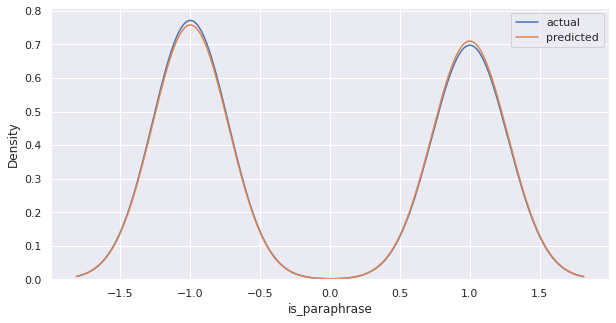

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', lr)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_test, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

Confusion matrix

In [ ]:
def conf_matrix(actual, predict, classes):
  
  cf_matrix = confusion_matrix(actual, predict)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  ax.xaxis.set_ticklabels(ticklabels=classes)
  ax.yaxis.set_ticklabels(ticklabels=classes)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  plt.rcParams.update({'font.size': 12})
  plt.show()
  return cf_matrix

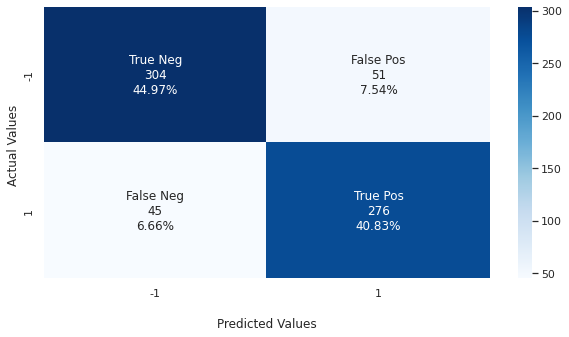

array([[304,  51],
       [ 45, 276]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

We can see that the model **predicts non-paraphrase (-1) slightly better**

Sensitivity/True Positive Rate tells us what proportion of the positive class got correctly classified.

In [ ]:
v = [value for value in matrix.flatten()]
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Positive Rate is 86%


Specificity/True Negative Rate tells us what proportion of the negative class got correctly classified.

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')

True Negative Rate is 86%


##### Feature importance

We'll try the following combinations:
* lexic trans. + syntactic trans. + sim. metric
* lexic trans. + syntactic trans.
* syntactic trans.
* syntactic trans. + sim. metric
* lexic trans. 
* lexic trans. + sim. metric
* sim. metrics

**lexic + syntactic + sim. metric**

In [ ]:
def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

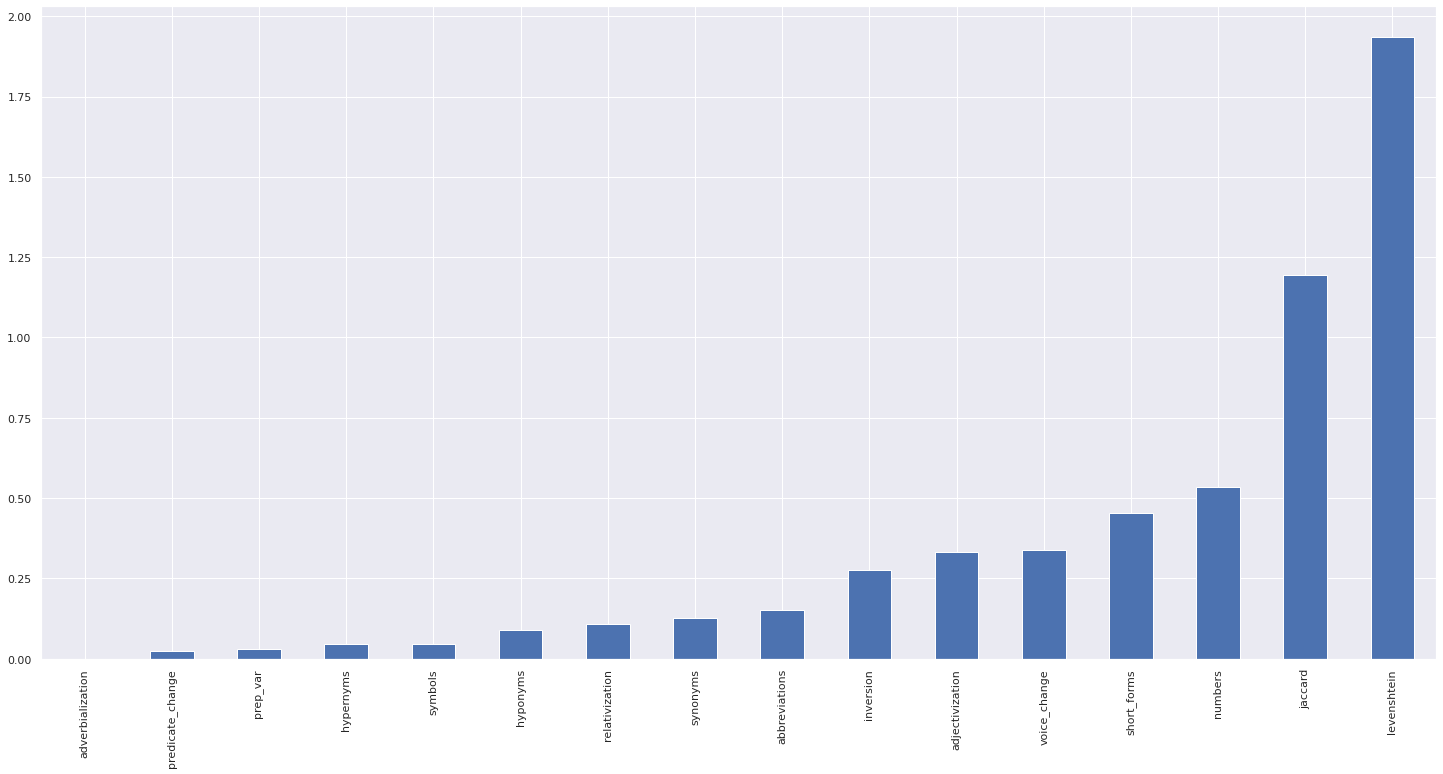

In [ ]:
plot_coef(lr.coef_, features2)

Analysis
* As expected string similarity metrics (jaccard & levenshtein) have the highest importancy in classification
* After string similarity metrics, numbers, short_forms, voice_change show top-3 results.

Let's try to classify **without string similarity** metrics

In [ ]:
no_sim_train = X_train.drop(['jaccard', 'levenshtein'], axis = 1)
no_sim_test = X_test.drop(['jaccard', 'levenshtein'], axis = 1)

pipe.fit(no_sim_train, y_train)
y_pred = pipe.predict(no_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.67      0.33      0.44       355
           1       0.53      0.83      0.64       321

    accuracy                           0.56       676
   macro avg       0.60      0.58      0.54       676
weighted avg       0.60      0.56      0.54       676



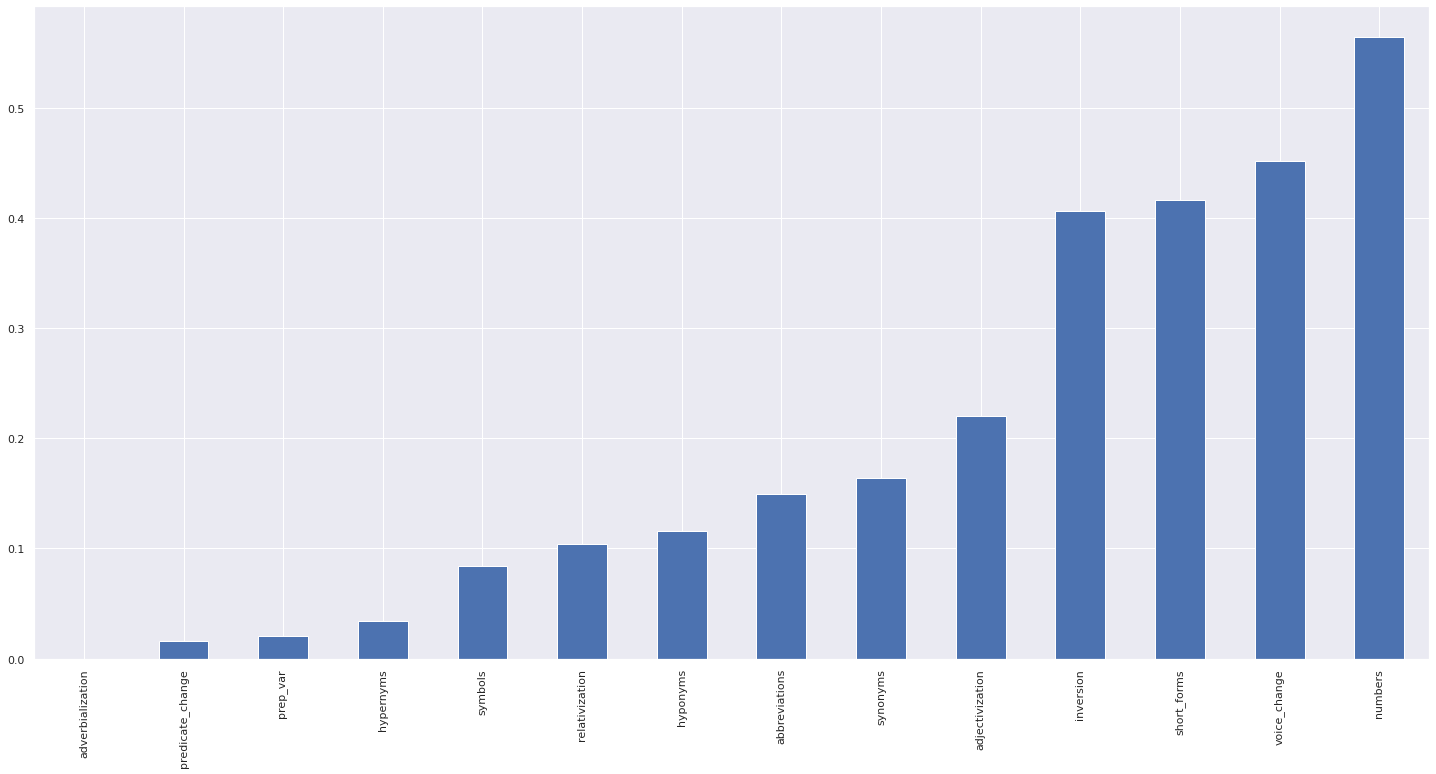

In [ ]:
plot_coef(lr.coef_, no_sim_train)

Looks like without similarity metrics, syntactic features have practically the same importance as lexic ones

We see that we get poor results (56% accuracy) without string similarity metrics

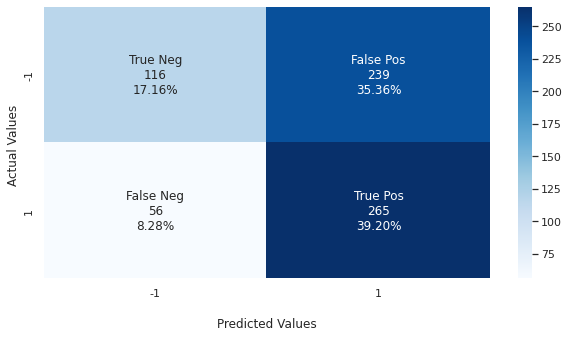

array([[116, 239],
       [ 56, 265]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 33%
True Positive Rate is 83%


Without similarity metrics, model starts to find non-paraphrases worse

Let's try classification with only syntactic and only lexic features

**Only syntactic features**:

In [ ]:
syn_train = X_train.drop(['jaccard', 'levenshtein', 'symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_test = X_test.drop(['jaccard', 'levenshtein', 'symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

pipe.fit(syn_train, y_train)
y_pred = pipe.predict(syn_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.34      0.44       355
           1       0.52      0.79      0.62       321

    accuracy                           0.55       676
   macro avg       0.58      0.56      0.53       676
weighted avg       0.58      0.55      0.53       676



The results are not far from lex + syn features

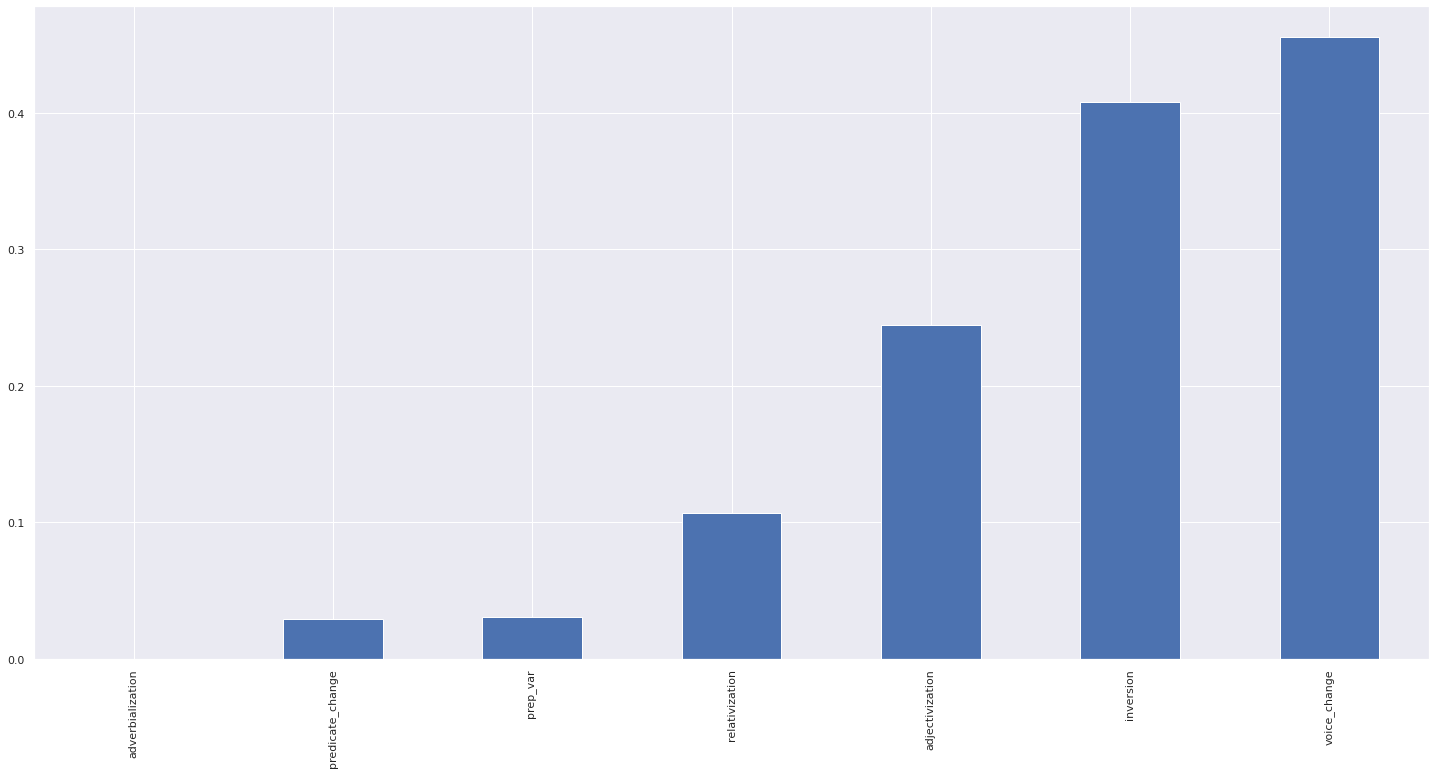

In [ ]:
plot_coef(lr.coef_, syn_train)

Voice_change, inversion and adjectivization have the highest importance among the sytactic features

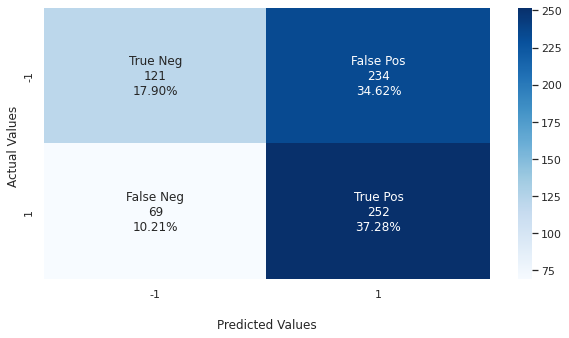

array([[121, 234],
       [ 69, 252]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 34%
True Positive Rate is 79%


The results changed not so much when we left out the lexic transformations

**Syntactic + similarity metrics**

In [ ]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

pipe.fit(syn_sim_train, y_train)
y_pred = pipe.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.84      0.85       355
           1       0.83      0.85      0.84       321

    accuracy                           0.85       676
   macro avg       0.85      0.85      0.85       676
weighted avg       0.85      0.85      0.85       676



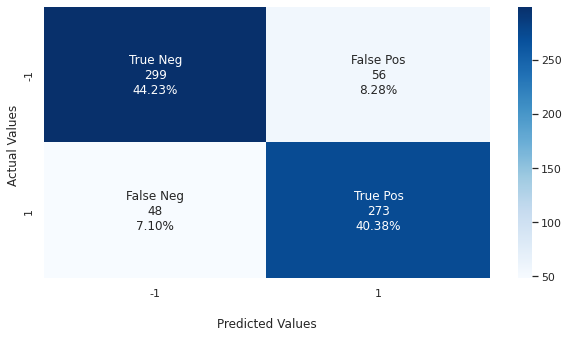

array([[299,  56],
       [ 48, 273]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 84%
True Positive Rate is 85%


Looks like syntactic + similarity metrics can show quite competitive results

**Only lexic transformations**:


In [ ]:
lex_train = X_train.drop(['jaccard', 'levenshtein','adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_test = X_test.drop(['jaccard', 'levenshtein', 'adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

pipe.fit(lex_train, y_train)
y_pred = pipe.predict(lex_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.56      0.92      0.70       355
           1       0.70      0.19      0.30       321

    accuracy                           0.58       676
   macro avg       0.63      0.56      0.50       676
weighted avg       0.62      0.58      0.51       676



Results are pretty the same with synt + lex & synt alone

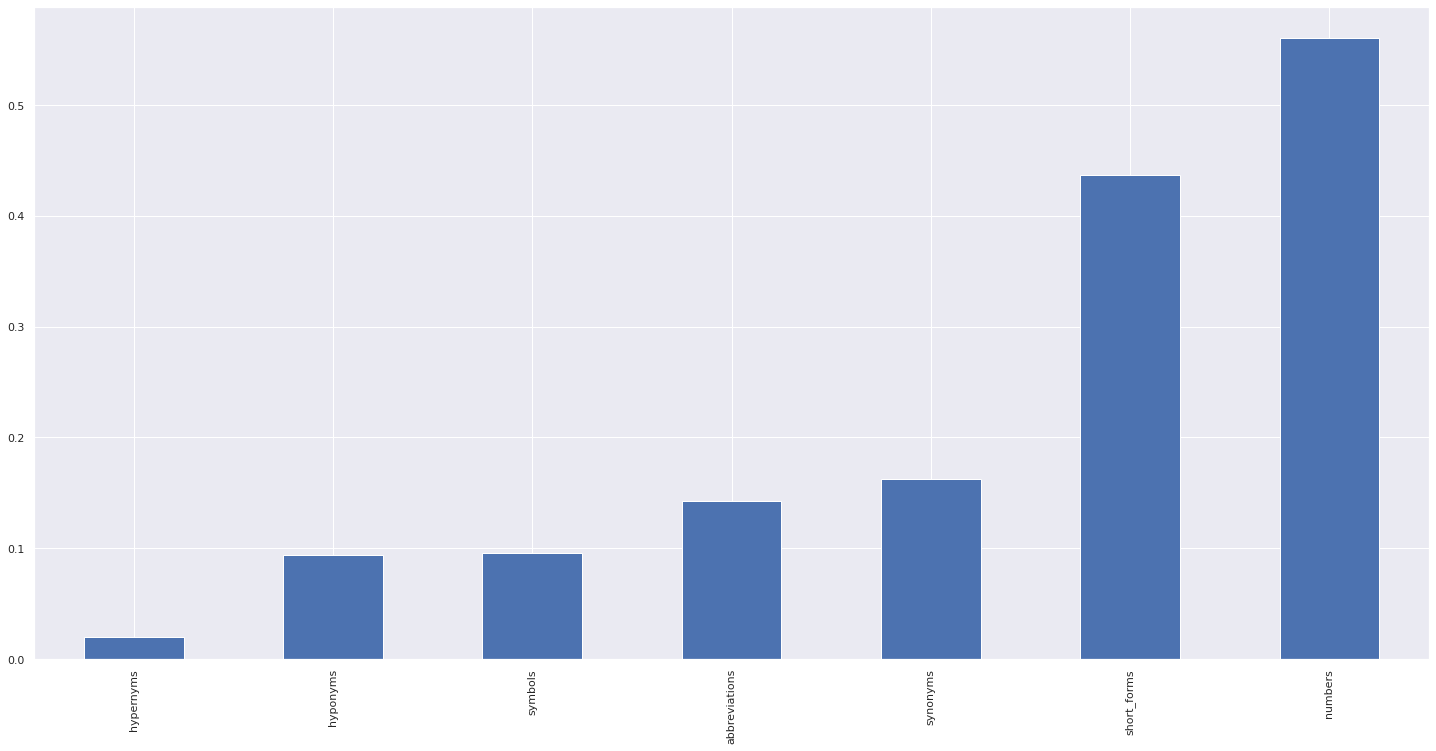

In [ ]:
plot_coef(lr.coef_, lex_train)

Numbers, short_forms, synonyms have the highest importance

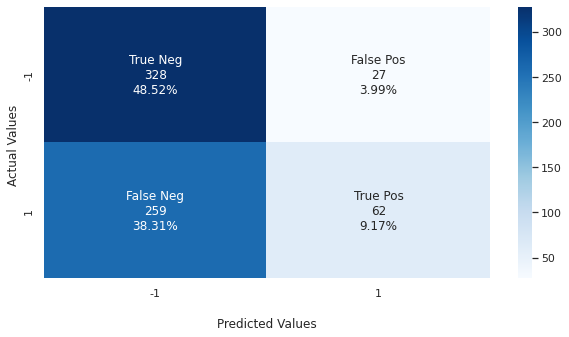

array([[328,  27],
       [259,  62]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 92%
True Positive Rate is 19%


Only lex features doesn't help to detect paraphrases

**Lexic + sim. metrics**

In [ ]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

pipe.fit(lex_sim_train, y_train)
y_pred = pipe.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.85      0.85       355
           1       0.83      0.85      0.84       321

    accuracy                           0.85       676
   macro avg       0.85      0.85      0.85       676
weighted avg       0.85      0.85      0.85       676



Very close to syn + sim metrics

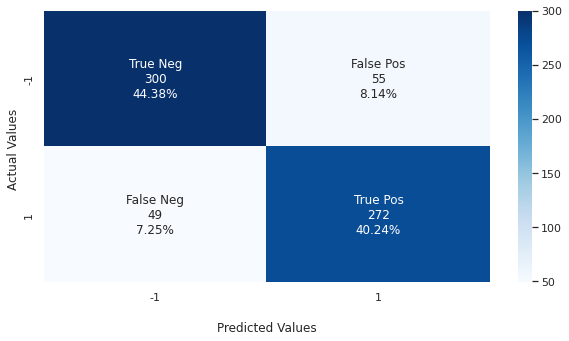

array([[300,  55],
       [ 49, 272]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 85%
True Positive Rate is 85%


**Sim. metrics**

In [ ]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

pipe.fit(sim_train, y_train)
y_pred = pipe.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.85      0.84      0.84       355
           1       0.82      0.83      0.83       321

    accuracy                           0.84       676
   macro avg       0.84      0.84      0.84       676
weighted avg       0.84      0.84      0.84       676



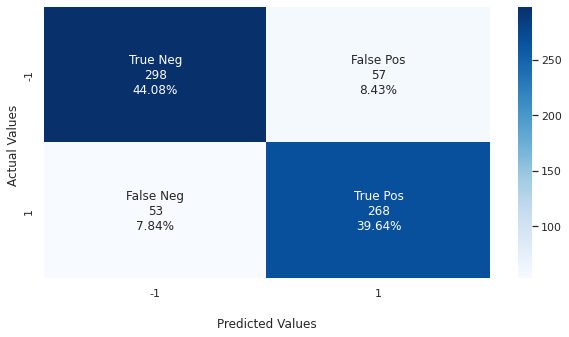

array([[298,  57],
       [ 53, 268]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 84%
True Positive Rate is 83%


##### Cross-validation

In [ ]:
%%time
tuned_parameters = [{'logistic__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}]
clf = GridSearchCV(
    pipe, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

clf.fit(X_val.values, y_val)

val_lr = clf.best_estimator_
val_lr.fit(X_train, y_train)
y_true, y_pred = y_test, val_lr.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
              precision    recall  f1-score   support

          -1       0.87      0.86      0.86       355
           1       0.84      0.85      0.85       321

    accuracy                           0.86       676
   macro avg       0.85      0.85      0.85       676
weighted avg       0.86      0.86      0.86       676

CPU times: user 513 ms, sys: 94.7 ms, total: 607 ms
Wall time: 3.38 s


So, unfortunately, syntactic + lex features improve the results not so much (only +2 points accuracy)

#### Random Forest

              precision    recall  f1-score   support

          -1       0.84      0.83      0.84       355
           1       0.82      0.83      0.82       321

    accuracy                           0.83       676
   macro avg       0.83      0.83      0.83       676
weighted avg       0.83      0.83      0.83       676



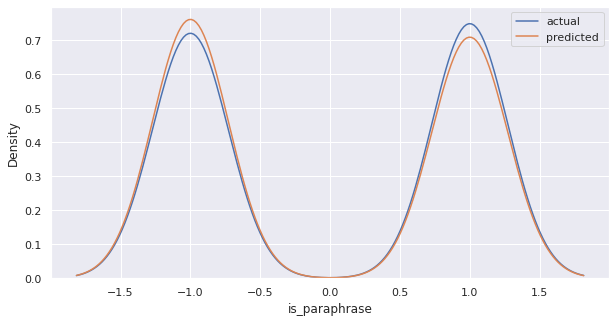

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
pipe_rf = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('random_forest', rf)])

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

In [ ]:
%%time
tuned_parameters = [{'random_forest__criterion': ['gini', 'entropy', 'log_loss'], 
                     'random_forest__max_features': ['auto', 'sqrt'],
                     'random_forest__max_depth': [10, 20, 30],
                     'random_forest__min_samples_leaf': [1, 2, 4],
                     'random_forest__min_samples_split': [2, 5, 10]}]

rf_val = GridSearchCV(                    
    pipe_rf, 
    tuned_parameters, 
    cv=5, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

rf_val.fit(X_val.values, y_val)
print(rf_val.best_estimator_)

rf_best = rf_val.best_estimator_
rf_best.fit(X_train, y_train)
y_true, y_pred = y_test, rf_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features='sqrt', min_samples_leaf=2,
                                        min_samples_split=10))])
              precision    recall  f1-score   support

          -1       0.89      0.83      0.86       355
           1       0.82      0.88      0.85       321

    accuracy                           0.85       676
   macro avg       0.85      0.86      0.85       676
weighted avg       0.86      0.85      0.85       676

CPU times: user 5.28 s, sys: 216 ms, total: 5.5 s
Wall time: 2min 18s


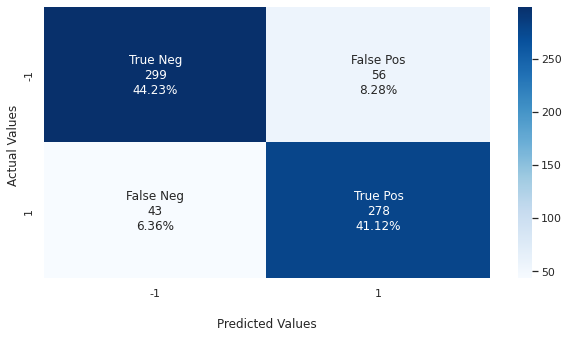

array([[299,  56],
       [ 43, 278]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, rf.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 84%
True Positive Rate is 87%


Results are competitive to logreg best model (86% accuracy)

In [ ]:
def plot_coef_rf(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

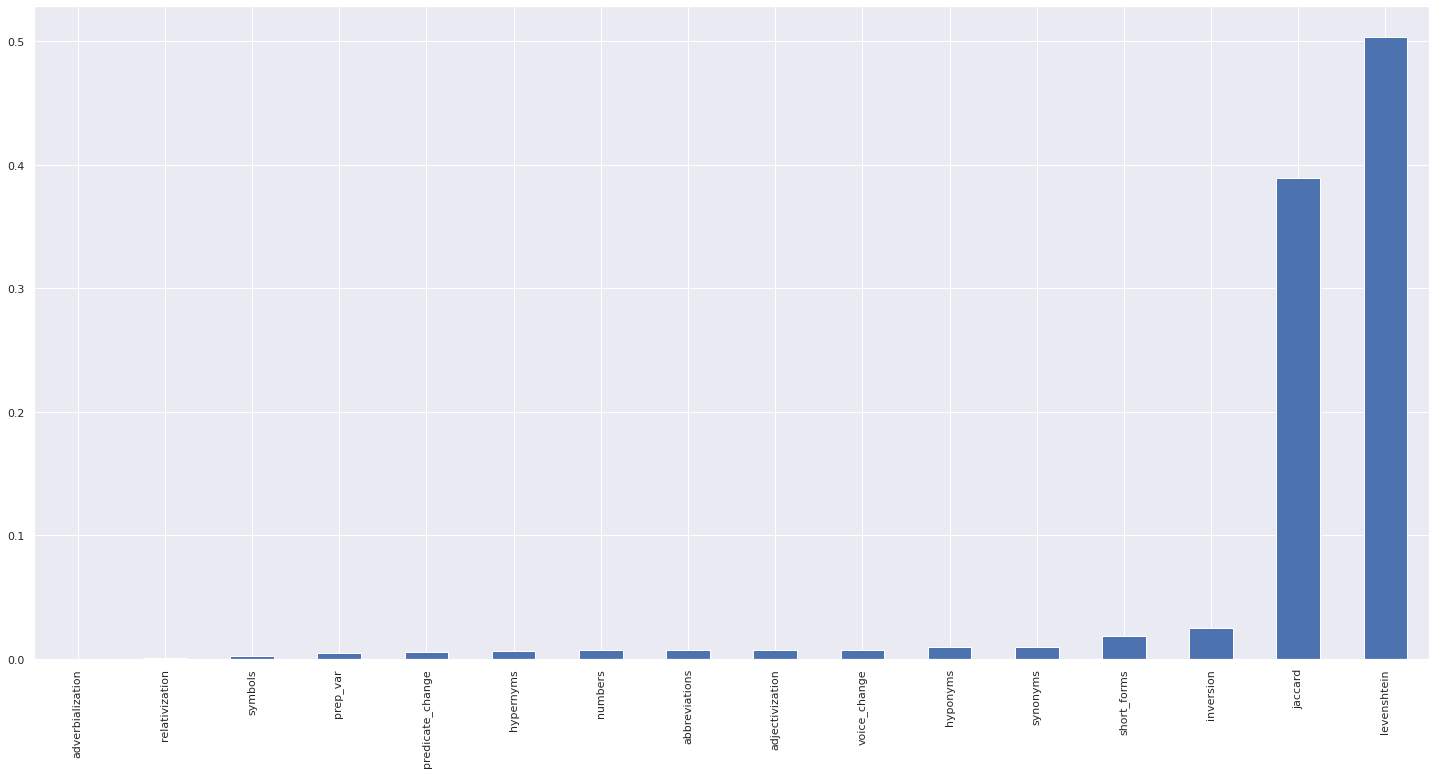

In [ ]:
plot_coef_rf(rf.feature_importances_, features2)

After sim metrics, inversion, short_forms, and synonyms are top-3

**Syntax + sim metrics**

In [ ]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

rf_best.fit(syn_sim_train, y_train)
y_pred = rf_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.84      0.85       355
           1       0.83      0.85      0.84       321

    accuracy                           0.84       676
   macro avg       0.84      0.85      0.84       676
weighted avg       0.85      0.84      0.84       676



**Lexics + sim metrics**

In [ ]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

rf_best.fit(lex_sim_train, y_train)
y_pred = rf_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.82      0.84       355
           1       0.81      0.87      0.84       321

    accuracy                           0.84       676
   macro avg       0.84      0.84      0.84       676
weighted avg       0.84      0.84      0.84       676



**Metrics**

In [ ]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

rf_best.fit(sim_train, y_train)
y_pred = rf_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.85      0.83      0.84       355
           1       0.81      0.84      0.83       321

    accuracy                           0.83       676
   macro avg       0.83      0.83      0.83       676
weighted avg       0.83      0.83      0.83       676



Lex + metrics or syn + metrics are better than syn+lex+metrics for RF

#### KNeighbors classifier

              precision    recall  f1-score   support

          -1       0.84      0.82      0.83       355
           1       0.81      0.83      0.82       321

    accuracy                           0.82       676
   macro avg       0.82      0.82      0.82       676
weighted avg       0.82      0.82      0.82       676



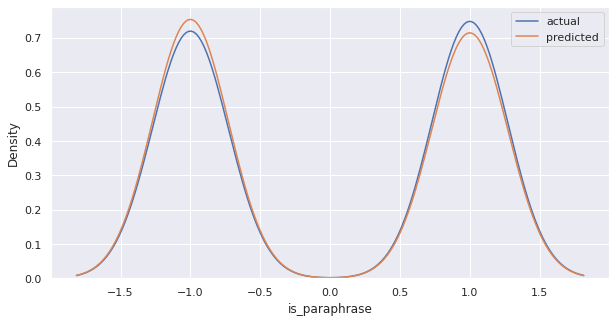

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn3 = KNeighborsClassifier(n_neighbors=3)
pipe_knn = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('knn', knn3)])

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

In [ ]:
%%time
knn = KNeighborsClassifier(algorithm='auto')
pipe_knn2 = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('knn', knn)])
tuned_parameters = [{'knn__n_neighbors': [1,2,3,4,5,6,7,8,9],
    'knn__weights': ('uniform', 'distance'),
    'knn__metric': ('minkowski', 'chebyshev')}]

knn_val = GridSearchCV(
    pipe_knn2, 
    tuned_parameters, 
    cv=5, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

knn_val.fit(X_val.values, y_val)
print(knn_val.best_estimator_)

knn_best = knn_val.best_estimator_
knn_best.fit(X_train, y_train)
y_true, y_pred = y_test, knn_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])
              precision    recall  f1-score   support

          -1       0.84      0.82      0.83       355
           1       0.81      0.83      0.82       321

    accuracy                           0.82       676
   macro avg       0.82      0.82      0.82       676
weighted avg       0.82      0.82      0.82       676

CPU times: user 465 ms, sys: 60.9 ms, total: 526 ms
Wall time: 1.26 s


Overall accuracy got worse

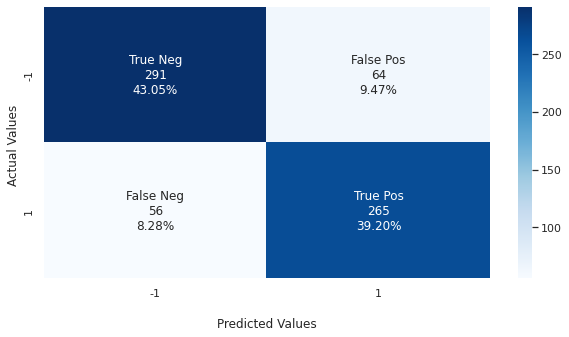

array([[291,  64],
       [ 56, 265]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 82%
True Positive Rate is 83%


**Syntax + similarity metrics**

In [ ]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

knn_best.fit(syn_sim_train, y_train)
y_pred = knn_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.85      0.84      0.84       355
           1       0.82      0.83      0.83       321

    accuracy                           0.84       676
   macro avg       0.84      0.84      0.84       676
weighted avg       0.84      0.84      0.84       676



**Lexics + metrics**

In [ ]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

knn_best.fit(lex_sim_train, y_train)
y_pred = knn_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.81      0.82       355
           1       0.80      0.83      0.81       321

    accuracy                           0.82       676
   macro avg       0.82      0.82      0.82       676
weighted avg       0.82      0.82      0.82       676



**Metrics**

In [ ]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

knn_best.fit(sim_train, y_train)
y_pred = knn_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.82      0.81       355
           1       0.79      0.79      0.79       321

    accuracy                           0.80       676
   macro avg       0.80      0.80      0.80       676
weighted avg       0.80      0.80      0.80       676



Syn + metrics show the best results

#### GaussianNB

              precision    recall  f1-score   support

          -1       0.55      0.97      0.71       355
           1       0.82      0.13      0.23       321

    accuracy                           0.57       676
   macro avg       0.69      0.55      0.47       676
weighted avg       0.68      0.57      0.48       676



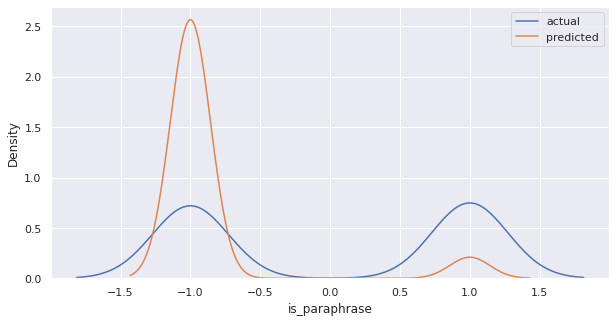

In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
pipe_gnb = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('GNB', GNB)])

pipe_gnb.fit(X_train, y_train)
y_pred = pipe_gnb.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

In [ ]:
%%time
tuned_parameters = [{'GNB__var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}]

ngb_val = GridSearchCV(
    pipe_gnb, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

ngb_val.fit(X_val.values, y_val)
print(ngb_val.best_estimator_)

ngb_best = ngb_val.best_estimator_
ngb_best.fit(X_train, y_train)
y_true, y_pred = y_test, ngb_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('GNB', GaussianNB(var_smoothing=0.0001))])
              precision    recall  f1-score   support

          -1       0.57      0.95      0.71       355
           1       0.78      0.20      0.32       321

    accuracy                           0.59       676
   macro avg       0.67      0.57      0.51       676
weighted avg       0.67      0.59      0.52       676

CPU times: user 186 ms, sys: 3.7 ms, total: 190 ms
Wall time: 374 ms


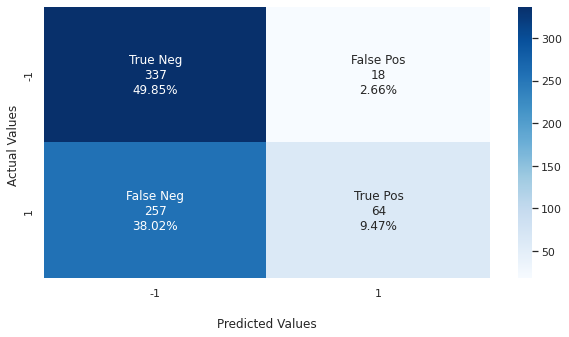

array([[337,  18],
       [257,  64]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 95%
True Positive Rate is 20%


The model fails to detect paraphrase class

In [ ]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

ngb_best.fit(syn_sim_train, y_train)
y_pred = ngb_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.96      0.75       355
           1       0.88      0.32      0.47       321

    accuracy                           0.66       676
   macro avg       0.75      0.64      0.61       676
weighted avg       0.74      0.66      0.62       676



In [ ]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

ngb_best.fit(lex_sim_train, y_train)
y_pred = ngb_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.95      0.72       355
           1       0.82      0.22      0.35       321

    accuracy                           0.61       676
   macro avg       0.70      0.59      0.53       676
weighted avg       0.69      0.61      0.54       676



Syntax helps to classify better

In [ ]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

ngb_best.fit(sim_train, y_train)
y_pred = ngb_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.83      0.84       355
           1       0.81      0.83      0.82       321

    accuracy                           0.83       676
   macro avg       0.83      0.83      0.83       676
weighted avg       0.83      0.83      0.83       676



#### SVC

              precision    recall  f1-score   support

          -1       0.86      0.86      0.86       355
           1       0.85      0.84      0.85       321

    accuracy                           0.85       676
   macro avg       0.85      0.85      0.85       676
weighted avg       0.85      0.85      0.85       676



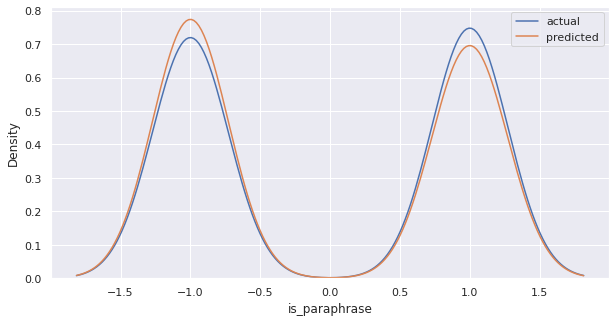

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel='linear')
pipe_svc = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('svc', svc)])

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

In [ ]:
%%time
tuned_parameters = [{'svc__C': [1, 10], 
          'svc__gamma': [0.001, 0.01, 1]}]

svc_val = GridSearchCV(
    pipe_svc, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

svc_val.fit(X_val.values, y_val)
print(svc_val.best_estimator_)

svc_best = svc_val.best_estimator_
svc_best.fit(X_train, y_train)
y_true, y_pred = y_test, svc_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=0.001, kernel='linear'))])
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86       355
           1       0.85      0.84      0.85       321

    accuracy                           0.85       676
   macro avg       0.85      0.85      0.85       676
weighted avg       0.85      0.85      0.85       676

CPU times: user 360 ms, sys: 3.69 ms, total: 364 ms
Wall time: 1.54 s


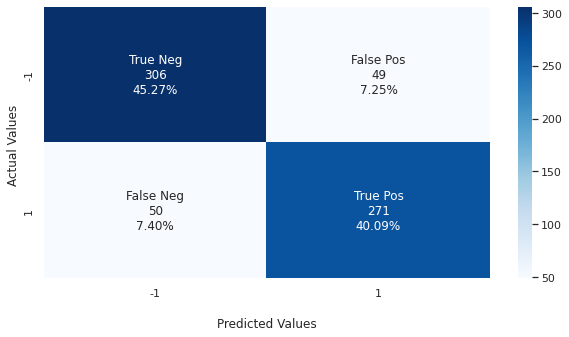

array([[306,  49],
       [ 50, 271]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 86%
True Positive Rate is 84%


Results are pretty the same with those of LR and RF

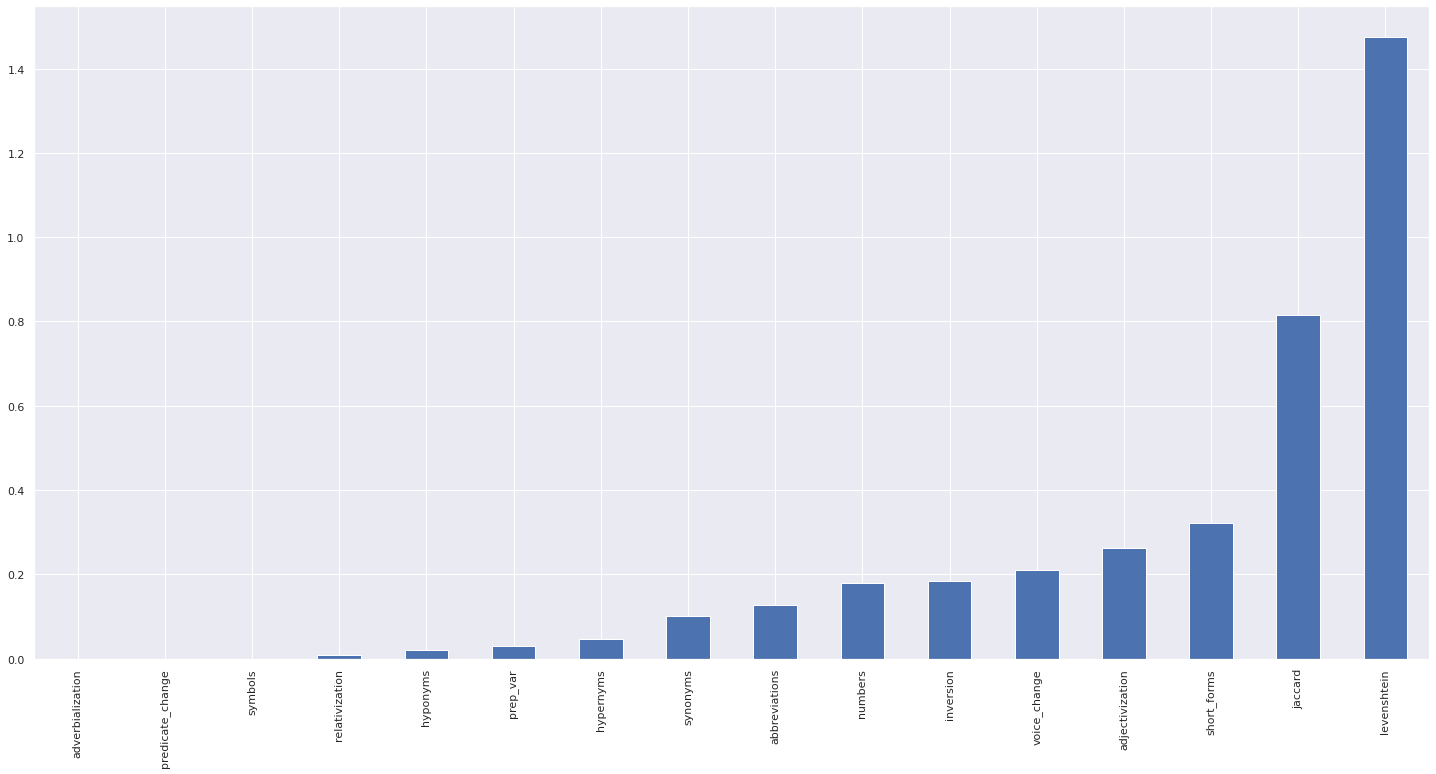

In [ ]:
plot_coef(svc.coef_, features2)

Short_form, adjectivization, and voice_change have high importance

In [ ]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

svc_best.fit(syn_sim_train, y_train)
y_pred = svc_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.86      0.85       355
           1       0.84      0.83      0.83       321

    accuracy                           0.84       676
   macro avg       0.84      0.84      0.84       676
weighted avg       0.84      0.84      0.84       676



In [ ]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

svc_best.fit(lex_sim_train, y_train)
y_pred = svc_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.85      0.85       355
           1       0.83      0.83      0.83       321

    accuracy                           0.84       676
   macro avg       0.84      0.84      0.84       676
weighted avg       0.84      0.84      0.84       676



In [ ]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

svc_best.fit(sim_train, y_train)
y_pred = svc_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.85      0.84       355
           1       0.83      0.81      0.82       321

    accuracy                           0.83       676
   macro avg       0.83      0.83      0.83       676
weighted avg       0.83      0.83      0.83       676



So, **Logistic Regression, Random Forest, and SVC** show best results out of five models in two-class classification

## Merge strict & loose paraphrases

Earlier on, we learned that our data is imbalanced and non-paraphrase examples prevail. Thus, we downsampled this class. Now, we'll merge strict paraphrases (1) and loose paraphrases (0) into one class of paraphrases opposed to the non-paraphrase class.

In [ ]:
two_class2 = df.copy(deep=True)
two_class2.loc[(two_class2['is_paraphrase'] == 0), ('is_paraphrase')] = 1

In [ ]:
two_class2['is_paraphrase'].value_counts()

 1    4645
-1    2582
Name: is_paraphrase, dtype: int64

In [ ]:
features = two_class2.copy(deep=True)
target = features.pop('is_paraphrase')
features = features.drop(['pair_id', 'id_1', 'id_2', 'text_1', 'text_2'], axis = 1)

X, y = RandomUnderSampler(random_state=42).fit_resample(features, target)
classes = Counter(y)
print(classes)

Counter({-1: 2582, 1: 2582})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

We implement models that showed the best results in previous classification

**Logistic regression**

              precision    recall  f1-score   support

          -1       0.81      0.80      0.81       525
           1       0.80      0.81      0.80       508

    accuracy                           0.80      1033
   macro avg       0.80      0.80      0.80      1033
weighted avg       0.80      0.80      0.80      1033



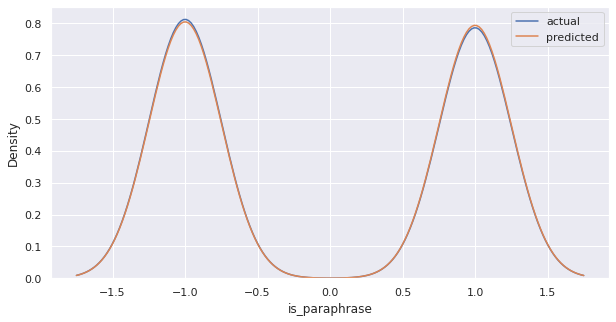

In [ ]:
val_lr.fit(X_train, y_train)
y_pred = val_lr.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_test, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

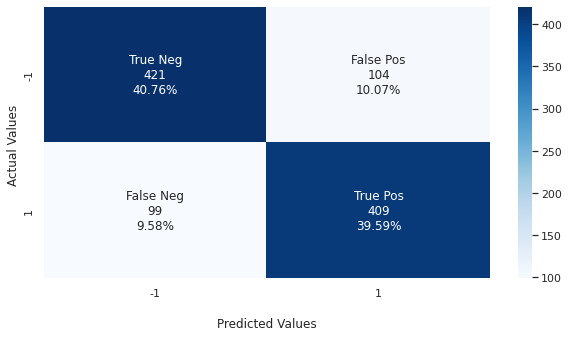

array([[421, 104],
       [ 99, 409]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, val_lr.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 80%
True Positive Rate is 81%


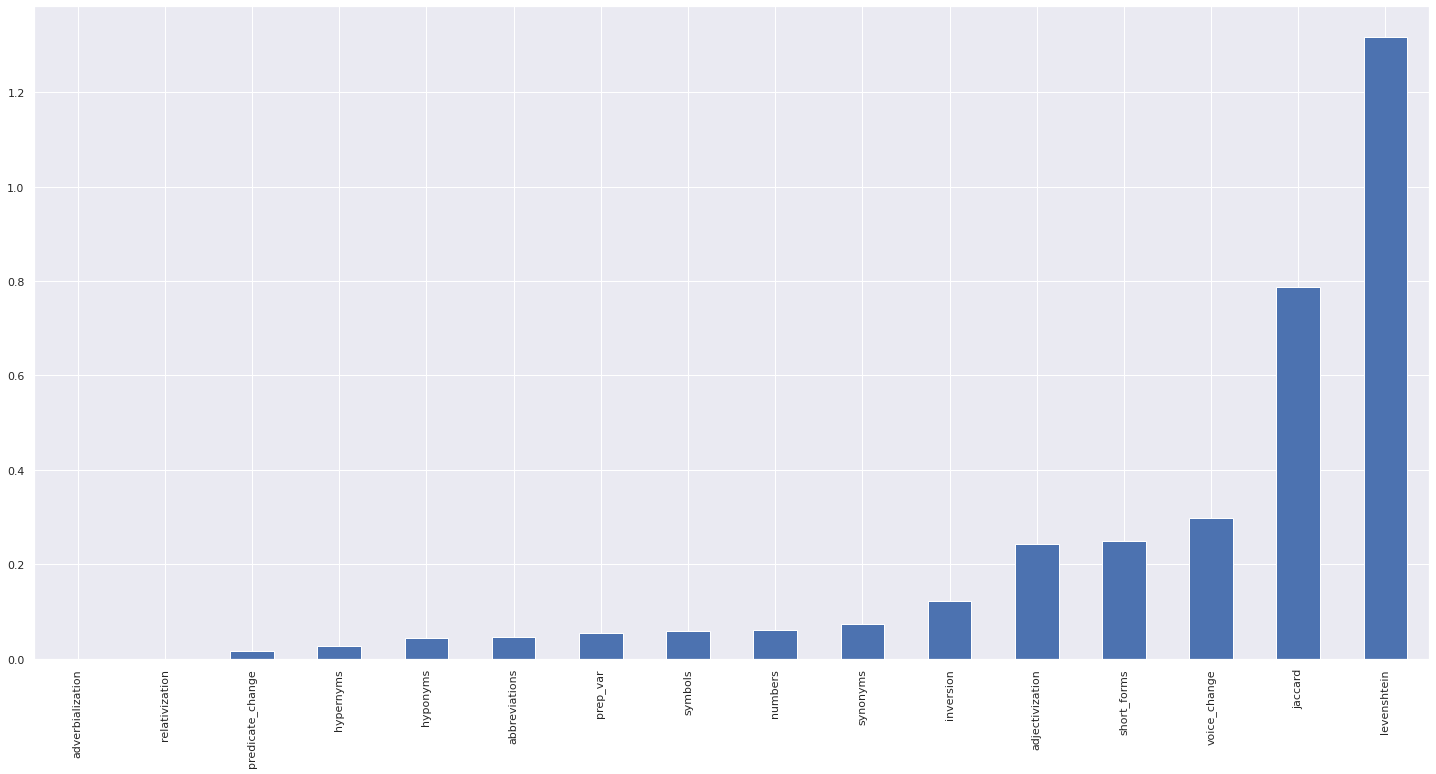

In [ ]:
plot_coef(lr.coef_, features)

**Random forest**

Fitting 5 folds for each of 162 candidates, totalling 810 fits
              precision    recall  f1-score   support

          -1       0.81      0.72      0.76       548
           1       0.72      0.81      0.76       485

    accuracy                           0.76      1033
   macro avg       0.76      0.76      0.76      1033
weighted avg       0.77      0.76      0.76      1033



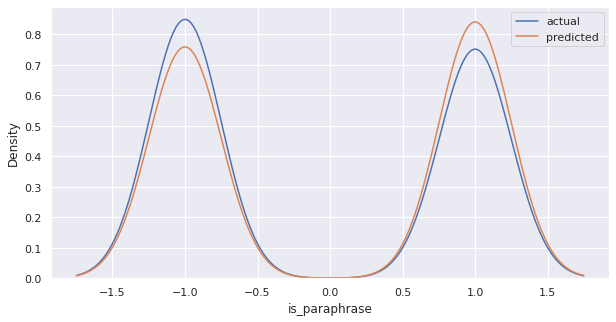

In [ ]:
rf_val.fit(X_train, y_train)
y_pred = rf_val.predict(X_val)
print(classification_report(y_val, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

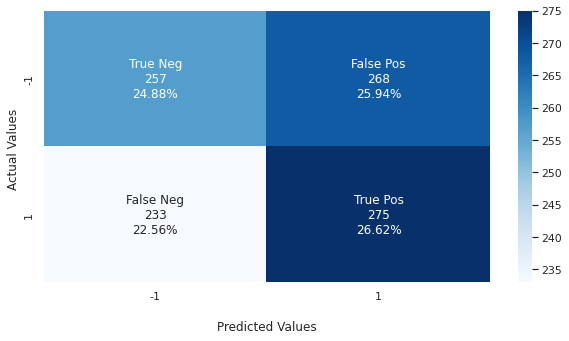

array([[257, 268],
       [233, 275]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, rf.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 49%
True Positive Rate is 54%


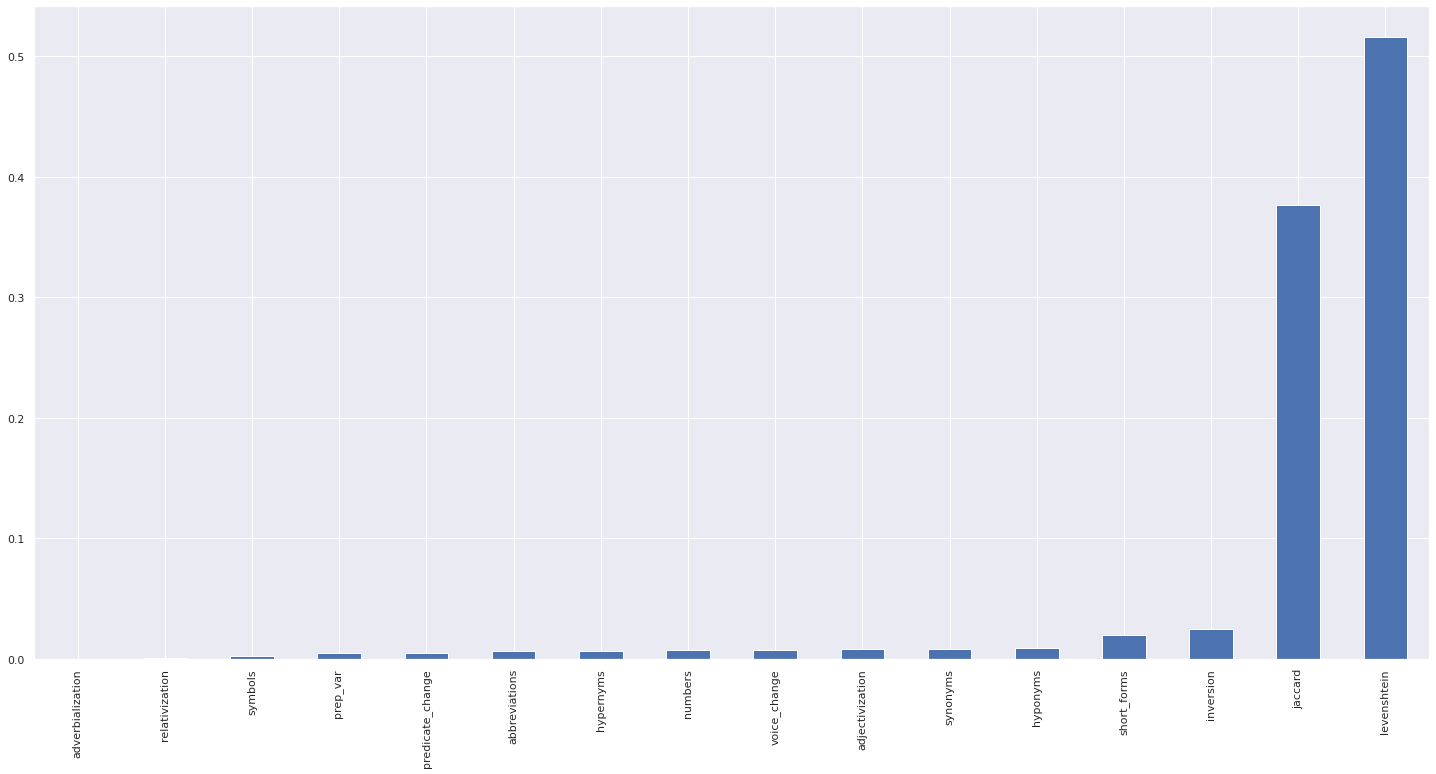

In [ ]:
plot_coef_rf(rf.feature_importances_, features2)

**SVC**

Fitting 10 folds for each of 6 candidates, totalling 60 fits
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78       548
           1       0.74      0.79      0.76       485

    accuracy                           0.77      1033
   macro avg       0.77      0.77      0.77      1033
weighted avg       0.77      0.77      0.77      1033



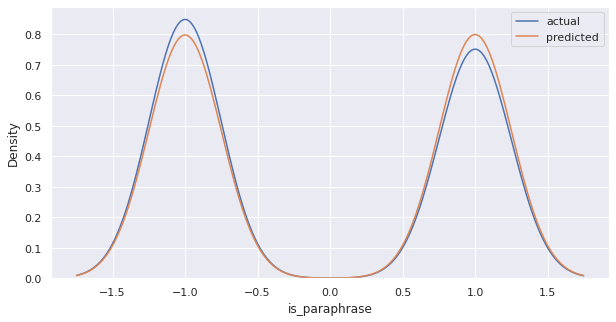

In [ ]:
svc_val.fit(X_train, y_train)
y_pred = svc_val.predict(X_val)
print(classification_report(y_val, y_pred))

sns.distplot(y_val, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

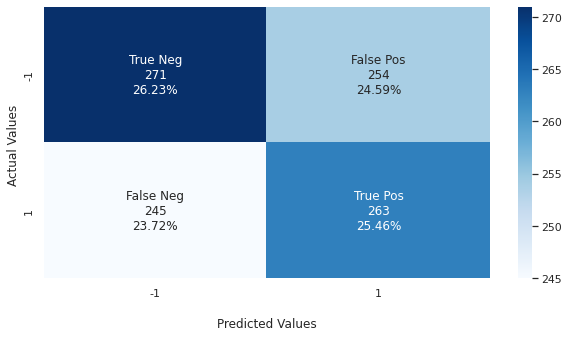

array([[271, 254],
       [245, 263]])

In [ ]:
matrix = conf_matrix(y_test, y_pred, svc.classes_)
matrix

In [ ]:
v = [value for value in matrix.flatten()]
TNR = round(v[0]/(v[0]+v[1])*100)
print(f'True Negative Rate is {TNR}%')
TPR = round(v[3]/(v[3]+v[2])*100)
print(f'True Positive Rate is {TPR}%')

True Negative Rate is 52%
True Positive Rate is 52%


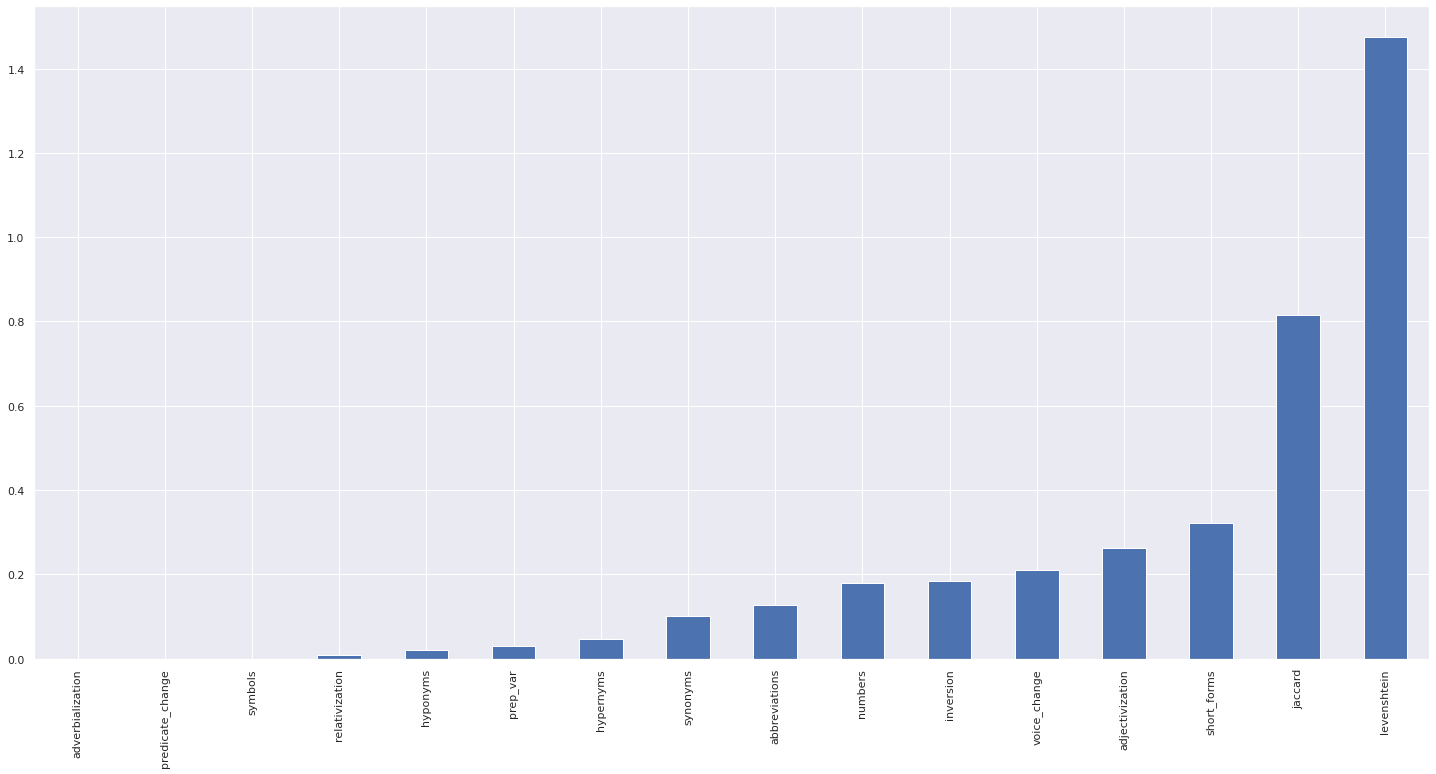

In [ ]:
plot_coef(svc.coef_, features)

Generally, results are lower with merged classes

# Mutliclass classification

Now we try classification with strict paraphrase (1), loose paraphrase (0), and non-paraphrase (-1) classes

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
from sklearn.model_selection import train_test_split

In [4]:
!wget https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/transformations.csv

--2022-06-12 11:16:57--  https://raw.githubusercontent.com/annatrn0/paraphrase_detection/main/data/transformations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2408156 (2.3M) [text/plain]
Saving to: ‘transformations.csv.1’

transformations.csv 100%[===================>]   2.30M  --.-KB/s    in 0.07s   

2022-06-12 11:16:57 (30.8 MB/s) - ‘transformations.csv.1’ saved [2408156/2408156]



In [7]:
df = pd.read_csv('/content/transformations.csv', index_col= 0)
df.head()

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase,jaccard,levenshtein,synonyms,hyponyms,...,numbers,short_forms,voice_change,adjectivization,adverbialization,relativization,predicate_change,prep_var,abbreviations,inversion
0,1,201,8159,"['полицейским', 'разрешат', 'стрелять', 'на', ...","['полиции', 'могут', 'разрешить', 'стрелять', ...",0,0.416667,67,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,202,8158,"['право', 'полицейских', 'на', 'проникновение'...","['правила', 'внесудебного', 'проникновения', '...",0,0.363636,63,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,273,8167,"['президент', 'египта', 'ввел', 'чрезвычайное'...","['власти', 'египта', 'угрожают', 'ввести', 'в'...",0,0.454545,66,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,220,8160,"['вернувшихся', 'из', 'сирии', 'россиян', 'вол...","['самолеты', 'мчс', 'вывезут', 'россиян', 'из'...",-1,0.230769,42,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,223,8160,"['в', 'москву', 'из', 'сирии', 'вернулись', '2...","['самолеты', 'мчс', 'вывезут', 'россиян', 'из'...",0,0.357143,62,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
df['is_paraphrase'].value_counts()

 0    2957
-1    2582
 1    1688
Name: is_paraphrase, dtype: int64

In [9]:
features = df.copy(deep=True)
target = features.pop('is_paraphrase')
features = features.drop(['pair_id', 'id_1', 'id_2', 'text_1', 'text_2'], axis = 1)

X, y = RandomUnderSampler(random_state=42).fit_resample(features, target)
classes = Counter(y)
print(classes)

Counter({-1: 1688, 0: 1688, 1: 1688})


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

We'll try all 5 models with 4 combinations:
* syntax + lexics + metrics
* syntax + metrics
* lexics + metrics
* metrics

### Logistic regression

**Syntax + lexics + Metrics**

              precision    recall  f1-score   support

          -1       0.77      0.73      0.75       352
           0       0.47      0.52      0.49       320
           1       0.65      0.62      0.63       341

    accuracy                           0.63      1013
   macro avg       0.63      0.62      0.62      1013
weighted avg       0.63      0.63      0.63      1013



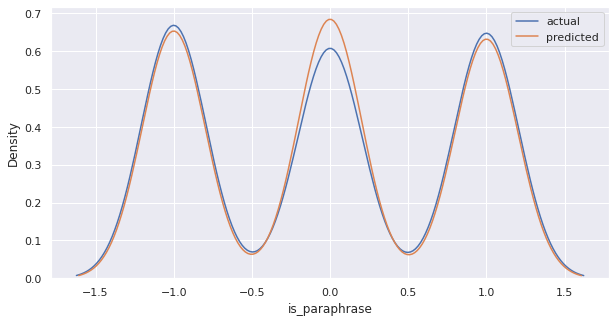

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', lr)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

sns.distplot(y_test, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

In [12]:
%%time
tuned_parameters = [{'logistic__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}]
clf = GridSearchCV(
    pipe, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

clf.fit(X_val.values, y_val)

val_lr = clf.best_estimator_
val_lr.fit(X_train, y_train)
y_true, y_pred = y_test, val_lr.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
              precision    recall  f1-score   support

          -1       0.77      0.73      0.75       352
           0       0.47      0.52      0.49       320
           1       0.65      0.62      0.63       341

    accuracy                           0.63      1013
   macro avg       0.63      0.62      0.62      1013
weighted avg       0.63      0.63      0.63      1013

CPU times: user 678 ms, sys: 63.2 ms, total: 742 ms
Wall time: 5.06 s


In [13]:
def conf_matrix(actual, predict, classes):
  
  cf_matrix = confusion_matrix(actual, predict)
  
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues')
  ax.xaxis.set_ticklabels(ticklabels=classes)
  ax.yaxis.set_ticklabels(ticklabels=classes)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  plt.rcParams.update({'font.size': 12})
  plt.show()
  return cf_matrix

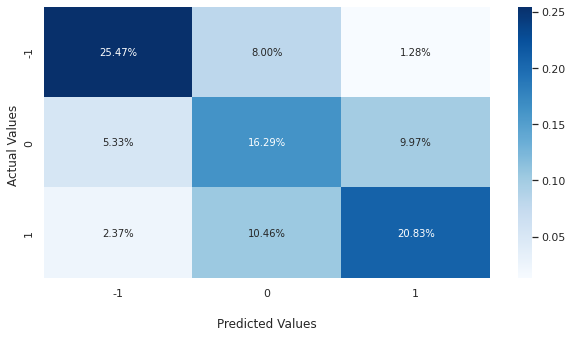

array([[258,  81,  13],
       [ 54, 165, 101],
       [ 24, 106, 211]])

In [14]:
matrix = conf_matrix(y_test, y_pred, lr.classes_)
matrix

In [17]:
v = [value for value in matrix.flatten()]

strict_par = round(v[8]/(v[8]+v[6]+v[7])*100)
print(f'Strict paraphrase accuracy is {strict_par}%')

loose_par = round(v[4]/(v[4]+v[3]+v[5])*100)
print(f'Loose paraphrase accuracy is {loose_par}%')

non_par = round(v[0]/(v[0]+v[1]+v[2])*100)
print(f'Non-paraphrase accuracy is {non_par}%')

Strict paraphrase accuracy is 62%
Loose paraphrase accuracy is 52%
Non-paraphrase accuracy is 73%


It's harder for model to detect loose paraphrases (0 class)

In [22]:
def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

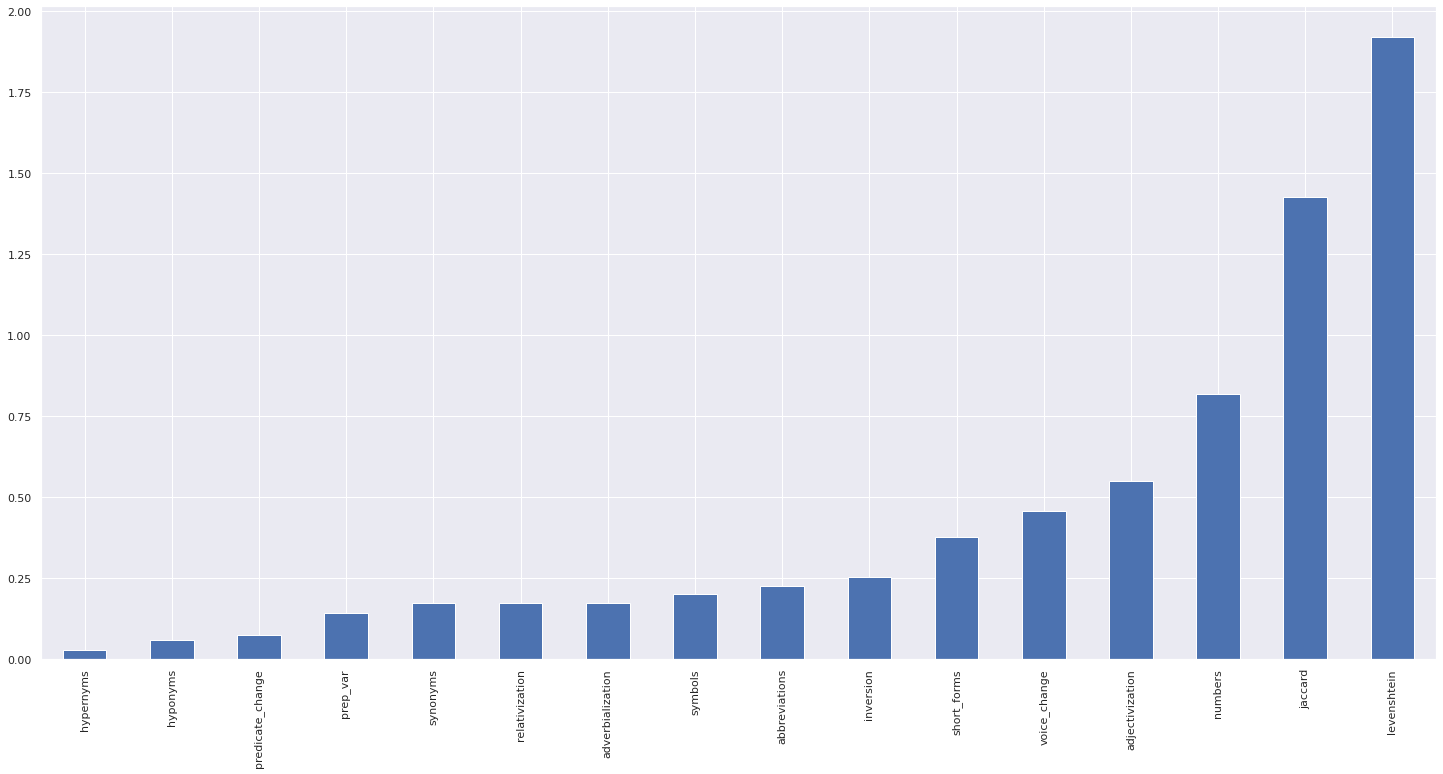

In [23]:
plot_coef(lr.coef_, features)

**Syn + metrics**

In [27]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

val_lr.fit(syn_sim_train, y_train)
y_pred = val_lr.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.72      0.74       352
           0       0.47      0.55      0.51       320
           1       0.65      0.60      0.62       341

    accuracy                           0.62      1013
   macro avg       0.63      0.62      0.62      1013
weighted avg       0.64      0.62      0.63      1013



**Lex + metrics**

In [31]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

val_lr.fit(lex_sim_train, y_train)
y_pred = val_lr.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.73      0.75       352
           0       0.47      0.51      0.49       320
           1       0.64      0.63      0.64       341

    accuracy                           0.63      1013
   macro avg       0.63      0.62      0.63      1013
weighted avg       0.63      0.63      0.63      1013



**Metrics**

In [32]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

val_lr.fit(sim_train, y_train)
y_pred = val_lr.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.71      0.74       352
           0       0.46      0.52      0.49       320
           1       0.63      0.61      0.62       341

    accuracy                           0.62      1013
   macro avg       0.62      0.61      0.62      1013
weighted avg       0.63      0.62      0.62      1013



### Random Forest

**Syntax + lexics + Metrics**

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
pipe_rf = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('random_forest', rf)])

tuned_parameters = [{'random_forest__criterion': ['gini', 'entropy', 'log_loss'], 
                     'random_forest__max_features': ['auto', 'sqrt'],
                     'random_forest__max_depth': [10, 20, 30],
                     'random_forest__min_samples_leaf': [1, 2, 4],
                     'random_forest__min_samples_split': [2, 5, 10]}]

rf_val = GridSearchCV(                    
    pipe_rf, 
    tuned_parameters, 
    cv=5, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

rf_val.fit(X_val.values, y_val)
print(rf_val.best_estimator_)

rf_best = rf_val.best_estimator_
rf_best.fit(X_train, y_train)
y_true, y_pred = y_test, rf_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(max_depth=30, max_features='sqrt',
                                        min_samples_leaf=4,
                                        min_samples_split=10))])
              precision    recall  f1-score   support

          -1       0.79      0.70      0.74       352
           0       0.45      0.51      0.48       320
           1       0.63      0.62      0.63       341

    accuracy                           0.62      1013
   macro avg       0.62      0.61      0.62      1013
weighted avg       0.63      0.62      0.62      1013

CPU times: user 6.69 s, sys: 309 ms, total: 7 s
Wall time: 2min 51s


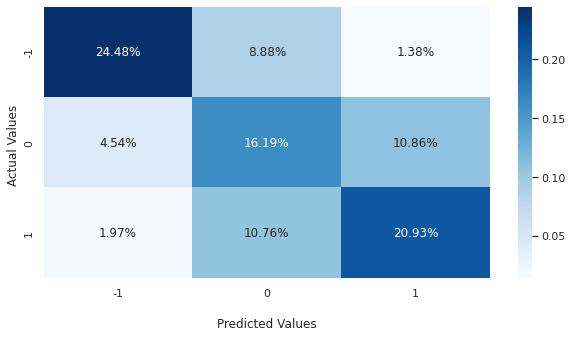

array([[248,  90,  14],
       [ 46, 164, 110],
       [ 20, 109, 212]])

In [42]:
matrix = conf_matrix(y_test, y_pred, rf_best.classes_)
matrix

In [43]:
v = [value for value in matrix.flatten()]

strict_par = round(v[8]/(v[8]+v[6]+v[7])*100)
print(f'Strict paraphrase accuracy is {strict_par}%')

loose_par = round(v[4]/(v[4]+v[3]+v[5])*100)
print(f'Loose paraphrase accuracy is {loose_par}%')

non_par = round(v[0]/(v[0]+v[1]+v[2])*100)
print(f'Non-paraphrase accuracy is {non_par}%')

Strict paraphrase accuracy is 62%
Loose paraphrase accuracy is 51%
Non-paraphrase accuracy is 70%


It's hard to detect loose paraphrases again

In [38]:
def plot_coef_rf(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

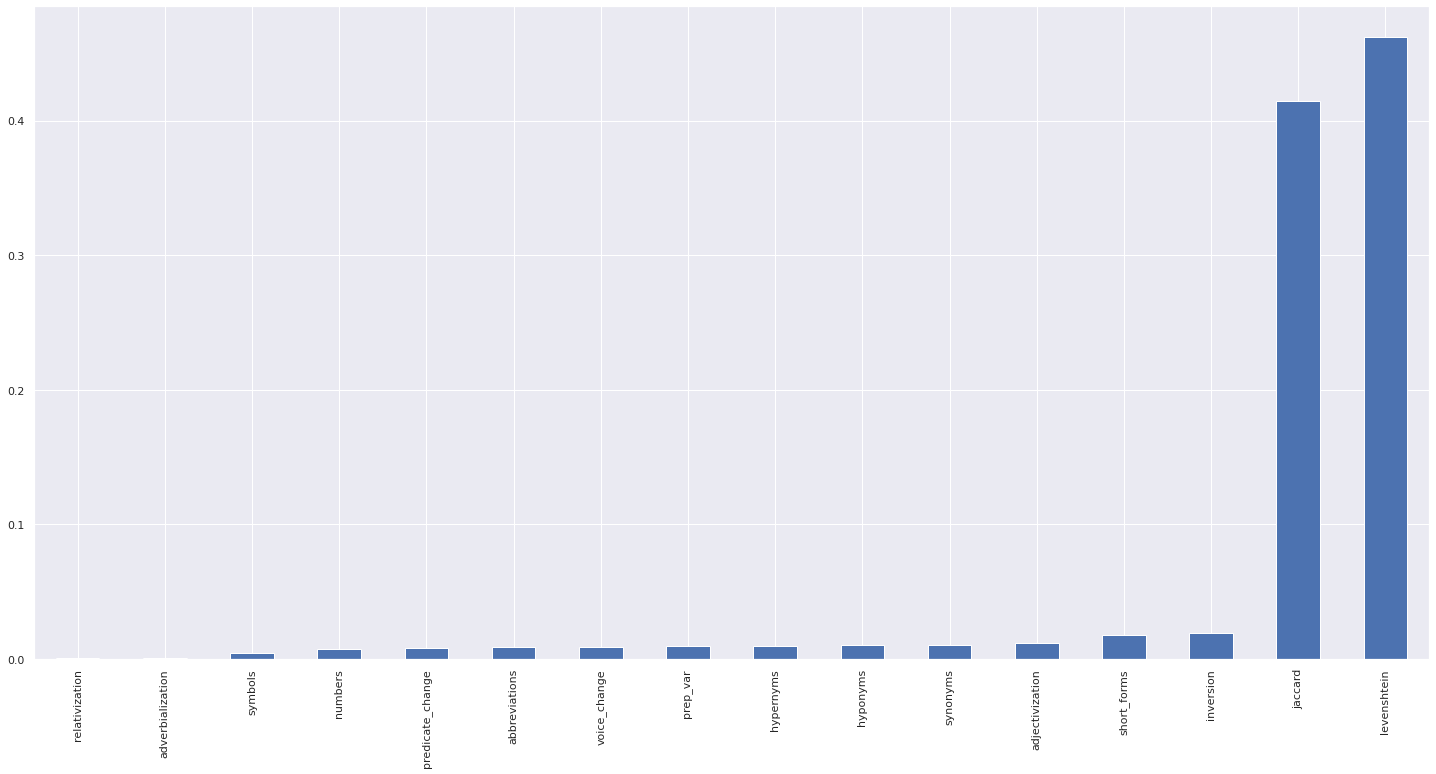

In [47]:
plot_coef_rf(rf.feature_importances_, features)

Metrics have the highest importance

**Syn + metrics**

In [48]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

rf_best.fit(syn_sim_train, y_train)
y_pred = rf_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.70      0.74       352
           0       0.44      0.50      0.47       320
           1       0.62      0.61      0.61       341

    accuracy                           0.61      1013
   macro avg       0.61      0.60      0.61      1013
weighted avg       0.62      0.61      0.61      1013



**Lex + metrics**

In [49]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

rf_best.fit(lex_sim_train, y_train)
y_pred = rf_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.71      0.75       352
           0       0.46      0.55      0.50       320
           1       0.65      0.61      0.63       341

    accuracy                           0.62      1013
   macro avg       0.64      0.62      0.63      1013
weighted avg       0.64      0.62      0.63      1013



**Metrics**

In [50]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

rf_best.fit(sim_train, y_train)
y_pred = rf_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.69      0.73       352
           0       0.45      0.51      0.48       320
           1       0.60      0.58      0.59       341

    accuracy                           0.60      1013
   macro avg       0.61      0.59      0.60      1013
weighted avg       0.61      0.60      0.60      1013



### KNeighbors classififer

**Syntax + lexics + Metrics**

In [53]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto')
pipe_knn2 = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('knn', knn)])
tuned_parameters = [{'knn__n_neighbors': [i for i in range(1,10)],
    'knn__weights': ('uniform', 'distance'),
    'knn__metric': ('minkowski', 'chebyshev')}]

knn_val = GridSearchCV(
    pipe_knn2, 
    tuned_parameters, 
    cv=5, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

knn_val.fit(X_val.values, y_val)
print(knn_val.best_estimator_)

knn_best = knn_val.best_estimator_
knn_best.fit(X_train, y_train)
y_true, y_pred = y_test, knn_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])
              precision    recall  f1-score   support

          -1       0.68      0.67      0.68       352
           0       0.41      0.48      0.44       320
           1       0.59      0.50      0.54       341

    accuracy                           0.55      1013
   macro avg       0.56      0.55      0.55      1013
weighted avg       0.56      0.55      0.56      1013

CPU times: user 627 ms, sys: 121 ms, total: 748 ms
Wall time: 4.95 s


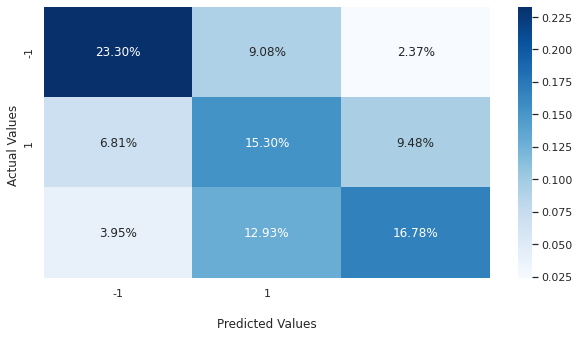

array([[236,  92,  24],
       [ 69, 155,  96],
       [ 40, 131, 170]])

In [54]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [55]:
v = [value for value in matrix.flatten()]

strict_par = round(v[8]/(v[8]+v[6]+v[7])*100)
print(f'Strict paraphrase accuracy is {strict_par}%')

loose_par = round(v[4]/(v[4]+v[3]+v[5])*100)
print(f'Loose paraphrase accuracy is {loose_par}%')

non_par = round(v[0]/(v[0]+v[1]+v[2])*100)
print(f'Non-paraphrase accuracy is {non_par}%')

Strict paraphrase accuracy is 50%
Loose paraphrase accuracy is 48%
Non-paraphrase accuracy is 67%


It's harder to detect loose and strict paraphrases

**Syntax + metrics**

In [56]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

knn_best.fit(syn_sim_train, y_train)
y_pred = knn_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.69      0.67       352
           0       0.40      0.46      0.43       320
           1       0.57      0.45      0.50       341

    accuracy                           0.54      1013
   macro avg       0.54      0.53      0.53      1013
weighted avg       0.54      0.54      0.54      1013



**Lexics + metrics**

In [57]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

knn_best.fit(lex_sim_train, y_train)
y_pred = knn_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.68      0.71      0.69       352
           0       0.43      0.49      0.45       320
           1       0.59      0.48      0.53       341

    accuracy                           0.56      1013
   macro avg       0.56      0.56      0.56      1013
weighted avg       0.57      0.56      0.56      1013



**Metrics**

In [58]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

knn_best.fit(sim_train, y_train)
y_pred = knn_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.71      0.68       352
           0       0.42      0.47      0.44       320
           1       0.58      0.45      0.51       341

    accuracy                           0.55      1013
   macro avg       0.55      0.54      0.54      1013
weighted avg       0.55      0.55      0.55      1013



### GaussianNB

**Syntax + Lexics + Metrics**

In [60]:
%%time
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
pipe_gnb = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('GNB', GNB)])
tuned_parameters = [{'GNB__var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}]

ngb_val = GridSearchCV(
    pipe_gnb, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

ngb_val.fit(X_val.values, y_val)
print(ngb_val.best_estimator_)

ngb_best = ngb_val.best_estimator_
ngb_best.fit(X_train, y_train)
y_true, y_pred = y_test, ngb_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('GNB', GaussianNB(var_smoothing=0.0001))])
              precision    recall  f1-score   support

          -1       0.52      0.90      0.66       352
           0       0.35      0.39      0.37       320
           1       0.66      0.09      0.16       341

    accuracy                           0.47      1013
   macro avg       0.51      0.46      0.40      1013
weighted avg       0.51      0.47      0.40      1013

CPU times: user 300 ms, sys: 52.4 ms, total: 353 ms
Wall time: 3.64 s


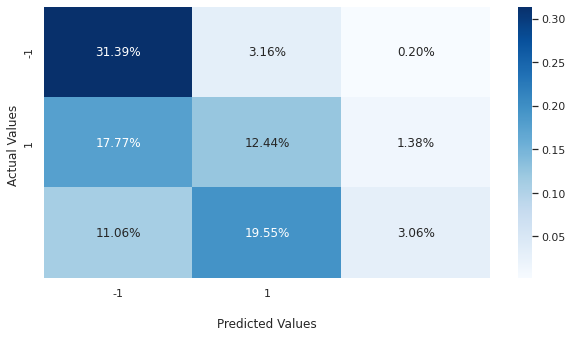

array([[318,  32,   2],
       [180, 126,  14],
       [112, 198,  31]])

In [61]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [62]:
v = [value for value in matrix.flatten()]

strict_par = round(v[8]/(v[8]+v[6]+v[7])*100)
print(f'Strict paraphrase accuracy is {strict_par}%')

loose_par = round(v[4]/(v[4]+v[3]+v[5])*100)
print(f'Loose paraphrase accuracy is {loose_par}%')

non_par = round(v[0]/(v[0]+v[1]+v[2])*100)
print(f'Non-paraphrase accuracy is {non_par}%')

Strict paraphrase accuracy is 9%
Loose paraphrase accuracy is 39%
Non-paraphrase accuracy is 90%


GB models predicts non-paraphrases mostly right

**Syntax + metrics**

In [65]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

ngb_best.fit(syn_sim_train, y_train)
y_pred = ngb_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.89      0.35      0.50       352
           0       0.36      0.97      0.52       320
           1       1.00      0.02      0.05       341

    accuracy                           0.44      1013
   macro avg       0.75      0.45      0.36      1013
weighted avg       0.76      0.44      0.35      1013



**Lexics + metrics**

In [63]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

ngb_best.fit(lex_sim_train, y_train)
y_pred = ngb_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.97      0.56       352
           0       0.33      0.03      0.06       320
           1       0.62      0.21      0.31       341

    accuracy                           0.42      1013
   macro avg       0.45      0.40      0.31      1013
weighted avg       0.45      0.42      0.32      1013



**Metrics**

In [64]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

ngb_best.fit(sim_train, y_train)
y_pred = ngb_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.68      0.72       352
           0       0.45      0.59      0.51       320
           1       0.66      0.55      0.60       341

    accuracy                           0.61      1013
   macro avg       0.63      0.61      0.61      1013
weighted avg       0.63      0.61      0.61      1013



### SVC

**Syntax + Lexics + Metrics**

In [79]:
%%time
from sklearn import svm
svc = svm.SVC(kernel='linear')
pipe_svc = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('svc', svc)])
tuned_parameters = [{'svc__C': [1, 10], 
          'svc__gamma': [0.001, 0.01, 1]}]

svc_val = GridSearchCV(
    pipe_svc, 
    tuned_parameters, 
    cv=10, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1)

svc_val.fit(X_val.values, y_val)
print(svc_val.best_estimator_)

svc_best = svc_val.best_estimator_
svc_best.fit(X_train, y_train)
y_true, y_pred = y_test, svc_best.predict(X_test)

print(classification_report(y_true, y_pred))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=0.001, kernel='linear'))])
              precision    recall  f1-score   support

          -1       0.79      0.65      0.71       352
           0       0.43      0.55      0.48       320
           1       0.64      0.60      0.62       341

    accuracy                           0.60      1013
   macro avg       0.62      0.60      0.61      1013
weighted avg       0.63      0.60      0.61      1013

CPU times: user 2.43 s, sys: 12.7 ms, total: 2.44 s
Wall time: 7.87 s


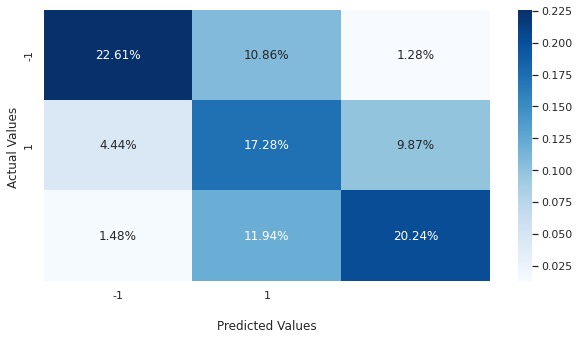

array([[229, 110,  13],
       [ 45, 175, 100],
       [ 15, 121, 205]])

In [80]:
matrix = conf_matrix(y_test, y_pred, [-1,1])
matrix

In [81]:
v = [value for value in matrix.flatten()]

strict_par = round(v[8]/(v[8]+v[6]+v[7])*100)
print(f'Strict paraphrase accuracy is {strict_par}%')

loose_par = round(v[4]/(v[4]+v[3]+v[5])*100)
print(f'Loose paraphrase accuracy is {loose_par}%')

non_par = round(v[0]/(v[0]+v[1]+v[2])*100)
print(f'Non-paraphrase accuracy is {non_par}%')

Strict paraphrase accuracy is 60%
Loose paraphrase accuracy is 55%
Non-paraphrase accuracy is 65%


We got the most 'even' results

**Syntax + metrics**

In [84]:
syn_sim_train = X_train.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)
syn_sim_test = X_test.drop(['symbols', 'hypernyms', 'hyponyms', 'synonyms', 'numbers', 'short_forms', 'abbreviations'], axis = 1)

svc_best.fit(syn_sim_train, y_train)
y_pred = svc_best.predict(syn_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.63      0.70       352
           0       0.43      0.57      0.49       320
           1       0.65      0.59      0.62       341

    accuracy                           0.60      1013
   macro avg       0.62      0.60      0.60      1013
weighted avg       0.63      0.60      0.61      1013



**Lexics + metrics**

In [85]:
lex_sim_train = X_train.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)
lex_sim_test = X_test.drop(['adverbialization', 'predicate_change', 'relativization', 'prep_var', 'adjectivization', 'inversion', 'voice_change'], axis = 1)

svc_best.fit(lex_sim_train, y_train)
y_pred = svc_best.predict(lex_sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.68      0.74       352
           0       0.46      0.58      0.51       320
           1       0.65      0.60      0.62       341

    accuracy                           0.62      1013
   macro avg       0.64      0.62      0.63      1013
weighted avg       0.65      0.62      0.63      1013



**Metrics**

In [86]:
sim_train = X_train[['jaccard', 'levenshtein']]
sim_test = X_test[['jaccard', 'levenshtein']]

svc_best.fit(sim_train, y_train)
y_pred = svc_best.predict(sim_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.63      0.70       352
           0       0.44      0.57      0.49       320
           1       0.64      0.59      0.61       341

    accuracy                           0.60      1013
   macro avg       0.62      0.60      0.60      1013
weighted avg       0.63      0.60      0.61      1013

